In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import plotly.express as px
import numpy as np
import gmaps
import gmaps.datasets 
from folium import Map
from folium.plugins import HeatMap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings('ignore')

# Because of the size of the dataset we must store the dataset in googlebigquery and then take the data as needed for our analysis

In [2]:
#Set environment variables for your notebook
import pyarrow 
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/amandamanfredo/Downloads/liquor_data.json'
#Imports google cloud client library and initiates BQ service
from google.cloud import bigquery
bigquery_client = bigquery.Client()
#Write Query on BQ
QUERY = """
SELECT date,store_number,store_name,address,city,zip_code,store_location,
county,category_name,vendor_number,vendor_name,item_description,pack,
bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,
sale_dollars,volume_sold_liters
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE  (date>='2012-01-01' AND date<'2022-03-01') AND store_name LIKE '%Hy-Vee%'
ORDER BY rand()
LIMIT 10000
  """
#Run the query and write result to a pandas data frame
Query_Results = bigquery_client.query(QUERY)
df = Query_Results.to_dataframe()
#View top few rows of result
df.head()

date store_number                           store_name  \
0  2019-10-11         2606   Hy-Vee Wine and Spirits / Humboldt   
1  2015-03-17         2552  Hy-Vee Food Store #3 / Cedar Rapids   
2  2020-04-27         2616       Hy-Vee Food and Drug / Clinton   
3  2020-10-13         2535           Hy-Vee Food Store #1 / WDM   
4  2020-06-16         2544     Hy-Vee Food Store / Marshalltown   

                 address             city zip_code  \
0    1011  13th St North         Humboldt    50548   
1  20 WILSON AVENUE WEST     CEDAR RAPIDS    52404   
2       901 South 4th St          Clinton  52732.0   
3    1700 Valley West Dr  West Des Moines    50265   
4       802 South Center     Marshalltown    50158   

                          store_location    county            category_name  \
0           POINT (-94.227116 42.733221)  HUMBOLDT            Mixto Tequila   
1           POINT (-91.658577 41.955859)      Linn              JAMAICA RUM   
2  POINT (-90.193204 41.836268000000004)   CLINTON               Triple Sec   
3                                   None      POLK  American Flavored Vodka   
4           POINT (-92.912817 42.039205)  MARSHALL        American Schnapps   

  vendor_number            vendor_name           item_description  pack  \
0         434.0              LUXCO INC                Juarez Gold    12   
1           260        Diageo Americas  Myers's Rum Original Dark    12   
2            65        Jim Beam Brands        Dekuyper Triple Sec    12   
3           205     E & J Gallo Winery    New Amsterdam Pineapple    12   
4            55  SAZERAC NORTH AMERICA          99 Root Beer Mini    10   

   bottle_volume_ml  state_bottle_cost  state_bottle_retail  bottles_sold  \
0              1000               7.83                11.75            24   
1              1000              12.50                18.75             3   
2              1000               2.33                 3.50            72   
3               750               7.50                11.25            12   
4                50               6.00                 9.00            10   

   sale_dollars  volume_sold_liters  
0        282.00                24.0  
1         56.25                 3.0  
2        252.00                72.0  
3        135.00                 9.0  
4         90.00                 0.5

In [3]:
df.shape

(10000, 19)

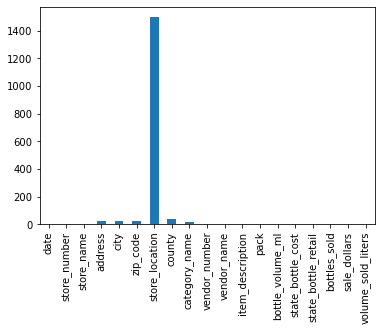

In [4]:
df.isna().sum().plot.bar(); 

In [5]:
#the dataframe is large enough that we can ignore null values and still have plenty of useful data to analyze
df.dropna(inplace=True)
df.drop_duplicates()

date store_number                           store_name  \
0     2019-10-11         2606   Hy-Vee Wine and Spirits / Humboldt   
1     2015-03-17         2552  Hy-Vee Food Store #3 / Cedar Rapids   
2     2020-04-27         2616       Hy-Vee Food and Drug / Clinton   
4     2020-06-16         2544     Hy-Vee Food Store / Marshalltown   
5     2013-06-15         2651                     Hy-Vee / Waverly   
...          ...          ...                                  ...   
9995  2018-12-03         2578                Hy-Vee / Charles City   
9996  2013-06-11         2649                  Hy-Vee #3 / Dubuque   
9997  2017-02-28         2605   Hy-Vee Drugstore #5 / Cedar Rapids   
9998  2016-06-28         2553          Hy-Vee Food Store / Creston   
9999  2014-04-23         2548          Hy-Vee Food Store / Altoona   

                        address          city zip_code  \
0           1011  13th St North      Humboldt    50548   
1         20 WILSON AVENUE WEST  CEDAR RAPIDS    52404   
2              901 South 4th St       Clinton  52732.0   
4              802 South Center  Marshalltown    50158   
5              1311 4 STREET SW       WAVERLY    50677   
...                         ...           ...      ...   
9995               901 Kelly St  Charles City  50616.0   
9996              400 LOCUST ST       DUBUQUE    52001   
9997  2001 Blairs Ferry Road NE  Cedar Rapids    52402   
9998                600 Sheldon       Creston    50801   
9999          100 8TH STREET SW       ALTOONA    50009   

                             store_location    county  \
0              POINT (-94.227116 42.733221)  HUMBOLDT   
1              POINT (-91.658577 41.955859)      Linn   
2     POINT (-90.193204 41.836268000000004)   CLINTON   
4              POINT (-92.912817 42.039205)  MARSHALL   
5              POINT (-92.475403 42.712263)    Bremer   
...                                     ...       ...   
9995           POINT (-92.675068 43.067104)     FLOYD   
9996   POINT (-90.666497 42.49721900000001)   Dubuque   
9997           POINT (-91.668909 42.034799)      LINN   
9998           POINT (-94.372552 41.051462)     Union   
9999           POINT (-93.465301 41.644041)      Polk   

                           category_name vendor_number  \
0                          Mixto Tequila         434.0   
1                            JAMAICA RUM           260   
2                             Triple Sec            65   
4                      American Schnapps            55   
5                     SINGLE MALT SCOTCH           420   
...                                  ...           ...   
9995                   American Schnapps          65.0   
9996                      VODKA 80 PROOF           205   
9997             American Flavored Vodka         260.0   
9998                   CANADIAN WHISKIES           115   
9999  MISC. IMPORTED CORDIALS & LIQUEURS           192   

                           vendor_name                       item_description  \
0                            LUXCO INC                            Juarez Gold   
1                      Diageo Americas              Myers's Rum Original Dark   
2                      Jim Beam Brands                    Dekuyper Triple Sec   
4                SAZERAC NORTH AMERICA                      99 Root Beer Mini   
5              Moet Hennessy USA, Inc.  Glenmorangie 10 Yr Single Malt Scotch   
...                                ...                                    ...   
9995                   Jim Beam Brands                  Dekuyper Grape Pucker   
9996              E AND J GALLO WINERY                    New Amsterdam Vodka   
9997                   DIAGEO AMERICAS                     Smirnoff Blueberry   
9998  Constellation Wine Company, Inc.                           Black Velvet   
9999        Sidney Frank Importing Co.                     Jagermeister Spice   

      pack  bottle_volume_ml  state_bottle_cost  state_bottle_retail  \
0       12              1000               7.83

In [6]:
#seeing how much the dataframe changes after dropping null values
df.shape

(8475, 19)

In [7]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8475 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 8475 non-null   object 
 1   store_number         8475 non-null   object 
 2   store_name           8475 non-null   object 
 3   address              8475 non-null   object 
 4   city                 8475 non-null   object 
 5   zip_code             8475 non-null   object 
 6   store_location       8475 non-null   object 
 7   county               8475 non-null   object 
 8   category_name        8475 non-null   object 
 9   vendor_number        8475 non-null   object 
 10  vendor_name          8475 non-null   object 
 11  item_description     8475 non-null   object 
 12  pack                 8475 non-null   int64  
 13  bottle_volume_ml     8475 non-null   int64  
 14  state_bottle_cost    8475 non-null   float64
 15  state_bottle_retail  8475 non-null   f

In [8]:
#trying to decrease the storage usage of the datset

#decreasing integer storage
df['bottle_volume_ml'] = df['bottle_volume_ml'].astype('int32')
df['pack'] = df['pack'].astype('int32')
df['bottles_sold'] = df['bottles_sold'].astype('int32')

#decreasing float memory usage
df['state_bottle_cost'] = df['state_bottle_cost'].astype('float32')
df['state_bottle_retail'] = df['state_bottle_retail'].astype('float32')
df['sale_dollars'] = df['sale_dollars'].astype('float32')
df['volume_sold_liters'] = df['volume_sold_liters'].astype('float32')

In [9]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8475 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 8475 non-null   object 
 1   store_number         8475 non-null   object 
 2   store_name           8475 non-null   object 
 3   address              8475 non-null   object 
 4   city                 8475 non-null   object 
 5   zip_code             8475 non-null   object 
 6   store_location       8475 non-null   object 
 7   county               8475 non-null   object 
 8   category_name        8475 non-null   object 
 9   vendor_number        8475 non-null   object 
 10  vendor_name          8475 non-null   object 
 11  item_description     8475 non-null   object 
 12  pack                 8475 non-null   int32  
 13  bottle_volume_ml     8475 non-null   int32  
 14  state_bottle_cost    8475 non-null   float32
 15  state_bottle_retail  8475 non-null   f

In [10]:
df['Profit_per_bottle']=df['state_bottle_retail']-df['state_bottle_cost']
df['Profit_per_sale']=df['Profit_per_bottle']*df['bottles_sold']
df.head(20)

date store_number                              store_name  \
0   2019-10-11         2606      Hy-Vee Wine and Spirits / Humboldt   
1   2015-03-17         2552     Hy-Vee Food Store #3 / Cedar Rapids   
2   2020-04-27         2616          Hy-Vee Food and Drug / Clinton   
4   2020-06-16         2544        Hy-Vee Food Store / Marshalltown   
5   2013-06-15         2651                        Hy-Vee / Waverly   
6   2012-04-10         2518       Hy-Vee Wine and Spirits / Red Oak   
7   2012-09-11         2584        Hy-Vee Food Store / Fort Madison   
8   2015-06-10         2576    Hy-Vee Wine and Spirits / Storm Lake   
9   2016-05-31         2641       Hy-Vee Drugstore / Council Bluffs   
12  2013-07-31         2633            Hy-Vee #3 / BDI / Des Moines   
13  2020-05-26         2671                    Hy-Vee  /  Jefferson   
15  2019-05-03         2668                Hy-Vee Food Store / Leon   
16  2016-01-13         2545            Hy-Vee Drugstore / Iowa City   
17  2018-03-15         2521      Hy-Vee Food and Drug / Grand / WDM   
18  2016-03-29         2508     Hy-Vee Food Store #1 / Cedar Rapids   
19  2019-03-08         2668                Hy-Vee Food Store / Leon   
20  2017-01-31         2624                     Hy-Vee #2 / Dubuque   
21  2019-10-31         2588  Hy-Vee Food and Drug #6 / Cedar Rapids   
22  2018-04-24         2587            Hy-Vee Food Store / Johnston   
23  2012-02-20         2633            Hy-Vee #3 / BDI / Des Moines   

                      address             city zip_code  \
0         1011  13th St North         Humboldt    50548   
1       20 WILSON AVENUE WEST     CEDAR RAPIDS    52404   
2            901 South 4th St          Clinton  52732.0   
4            802 South Center     Marshalltown    50158   
5            1311 4 STREET SW          WAVERLY    50677   
6         1607 NORTH BROADWAY          RED OAK    51566   
7               2606 AVENUE L     FORT MADISON    52627   
8              1250 N LAKE ST       STORM LAKE    50588   
9              757 W Broadway   Council Bluffs    51501   
12            3221 SE 14TH ST       DES MOINES    50320   
13       106, W Washington St        Jefferson  50129.0   
15              1004 W 1st St             Leon    50144   
16               310 N 1ST ST        IOWA CITY    52245   
17          1990 Grand Avenue  West Des Moines  50265.0   
18  1843 JOHNSON AVENUE, N.W.     CEDAR RAPIDS    52405   
19              1004 W 1st St             Leon    50144   
20        2395 NW Arterial Rd          Dubuque    52002   
21       4035 Mt Vernon Rd SE     Cedar Rapids    52403   
22        5750 Merle Hay Road         Johnston  50131.0   
23            3221 SE 14TH ST       DES MOINES    50320   

                           store_location         county  \
0            POINT (-94.227116 42.733221)       HUMBOLDT   
1            POINT (-91.658577 41.955859)           Linn   
2   POINT (-90.193204 41.836268000000004)        CLINTON   
4            POINT (-92.912817 42.039205)       MARSHALL   
5            POINT (-92.475403 42.712263)         Bremer   
6             POINT (-95.83539 41.279189)     Montgomery   
7            POINT (-91.343544 40.626988)            Lee   
8    POINT (-95.200758 42.65318400000001)    Buena Vista   
9            POINT (-95.855054 41.261673)  Pottawattamie   
12           POINT (-93.596754 41.554101)           Polk   
13           POINT (-94.375508 42.017267)         GREENE   
15           POINT (-93.757827 40.739645)        DECATUR   
16           POINT (-91.528105 42.207428)        Johnson   
17            POINT (-93.73162 41.571127)           POLK   
18            POINT (-91.697941 41.97447)           Linn   
19           POINT (-93.757827 40.739645)        DECATUR   
20           POINT (-90.741064 42.516633)        DUBUQUE   
21            POINT (-91.60978 41.976835)           LINN   
22           POINT (-93.697731 41.665172)           POLK   
23           POINT (-93.596754 41.554101)           Polk   

                c

In [11]:
#getting an idea of the average profit per bottle
print('mean:',df['Profit_per_bottle'].mean())

#getting an idea of median profit since a few expensive/profitable bottles can skew mean
print('median:',df['Profit_per_bottle'].median())

#finding the max profit per bottle
df.loc[df['Profit_per_bottle'] == df['Profit_per_bottle'].max()] 

mean: 5.2002058029174805
median: 4.239999771118164


date store_number                      store_name  \
3224  2021-09-23         2627  Hy-Vee Wine & Spirits #1 / MLK   

                              address        city zip_code  \
3224  3330 Martin Luther King Jr Pkwy  Des Moines    50310   

                            store_location county      category_name  \
3224  POINT (-93.65078800000002 41.625924)   POLK  Canadian Whiskies   

     vendor_number      vendor_name                     item_description  \
3224            65  Jim Beam Brands  HA Canadian Club Chronicles 43 Year   

      pack  bottle_volume_ml  state_bottle_cost  state_bottle_retail  \
3224     6               750              165.0                247.5   

      bottles_sold  sale_dollars  volume_sold_liters  Profit_per_bottle  \
3224             1         247.5                0.75               82.5   

      Profit_per_sale  
3224             82.5

array([[<AxesSubplot:title={'center':'Profit_per_bottle'}>]], dtype=object)

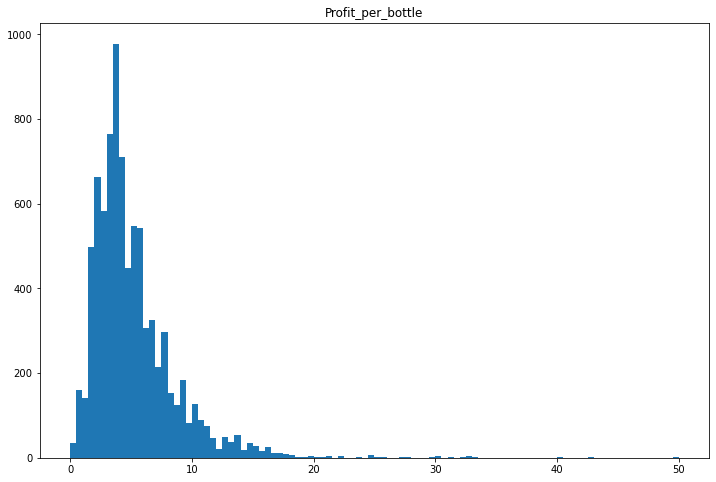

In [12]:
#seeing the distribution of profit per bottle
df.hist(column='Profit_per_bottle', bins=100, grid=False, figsize=(12,8),range=[0, 50])

In [13]:
df['category_name'].nunique()

115

In [14]:
#turning the store names to lowercase to prevent discrepancies
df['store_name'] = df['store_name'].str.lower()

df['category_name'] = df['category_name'].str.lower()

In [15]:
#defining a function to create a column of the different store types for hy-vee
def store(b):
    if ('quick' in b) or ('kwik' in b) or ('conven' in b) or ('fresh' in b) or ('c-store' in b):
        return 'Convenience'
    elif ('gas' in b) or ('petro' in b) or ('fuel' in b):
        return 'Gas'
    elif ('liquor' in b) or ('spirits' in b) or ('beverage' in b) or ('bottle' in b) or ('distil' in b) or ('wine' in b):
        return 'Liquor Store'
    elif ('drug' in b) or ('pharmacy' in b):
        return 'Drug Store'
    else:
        return 'Supermarket'

df['Store Type'] = df.store_name.apply(lambda y: store(y))

In [16]:
df['Store Type'].value_counts()

Supermarket     5547
Liquor Store    1619
Drug Store      1268
Convenience       35
Gas                6
Name: Store Type, dtype: int64

In [17]:
#making a function to classify the different liquor types into a column

def func(a):
    if "vodka" in a:
        return "vodka"
    elif "tequila" in a:
        return "tequila"
    elif "rum" in a:
        return "rum"
    elif "gin" in a:
        return "gin"
    elif "wine" in a:
        return "wine"
    elif "beer" in a:
        return "beer"
    elif "wine" in a:
        return "wine"
    elif "brand" in a:
        return "brandy"
    elif ('liqueur' in a) or ("triple" in a):
        return 'liqueurs'
    elif "schnap" in a:
        return "schnapps"
    elif ('grain spirits' in a):
        return 'moonshine'
    elif ('mezcal' in a):
        return 'mezcal'
    elif ('cocktail' in a):
        return 'cocktail mix'
    elif 'special' in a:
        return "gifts"
    elif "whisk" in a or "bourbon" in a or "scotch" in a:
        return "whisky/bourbon/scotch"
    else:
        return "Other"

df["LiquorType"] = df.category_name.apply(lambda x: func(x))

In [18]:
df['LiquorType'].value_counts()

whisky/bourbon/scotch    2244
vodka                    2113
liqueurs                 1059
rum                       943
schnapps                  466
tequila                   399
gin                       372
brandy                    343
cocktail mix              298
gifts                     129
Other                      59
moonshine                  42
beer                        5
mezcal                      3
Name: LiquorType, dtype: int64

In [19]:
#turing the column to str so we can make this function
df.bottle_volume_ml = df.bottle_volume_ml.astype(str)

In [20]:
#making a function to convert bottle volume into categories
def bottle(c):
    if "750" in c:
        return "750"
    elif "1750" in c:
        return "1750"
    elif "375" in c:
        return "375"
    elif "50" in c:
        return "c"
    elif "1000" in c:
        return "1000"
    elif "200" in c:
        return "200"
    elif "100" in c:
        return "100"
    else:
        return "Other"

df['Bottle Size'] = df.bottle_volume_ml.apply(lambda y: bottle(y))

In [21]:
#dropping original column since its now repetitive
df = df.drop('bottle_volume_ml', 1)

In [22]:
df

date store_number                           store_name  \
0     2019-10-11         2606   hy-vee wine and spirits / humboldt   
1     2015-03-17         2552  hy-vee food store #3 / cedar rapids   
2     2020-04-27         2616       hy-vee food and drug / clinton   
4     2020-06-16         2544     hy-vee food store / marshalltown   
5     2013-06-15         2651                     hy-vee / waverly   
...          ...          ...                                  ...   
9995  2018-12-03         2578                hy-vee / charles city   
9996  2013-06-11         2649                  hy-vee #3 / dubuque   
9997  2017-02-28         2605   hy-vee drugstore #5 / cedar rapids   
9998  2016-06-28         2553          hy-vee food store / creston   
9999  2014-04-23         2548          hy-vee food store / altoona   

                        address          city zip_code  \
0           1011  13th St North      Humboldt    50548   
1         20 WILSON AVENUE WEST  CEDAR RAPIDS    52404   
2              901 South 4th St       Clinton  52732.0   
4              802 South Center  Marshalltown    50158   
5              1311 4 STREET SW       WAVERLY    50677   
...                         ...           ...      ...   
9995               901 Kelly St  Charles City  50616.0   
9996              400 LOCUST ST       DUBUQUE    52001   
9997  2001 Blairs Ferry Road NE  Cedar Rapids    52402   
9998                600 Sheldon       Creston    50801   
9999          100 8TH STREET SW       ALTOONA    50009   

                             store_location    county  \
0              POINT (-94.227116 42.733221)  HUMBOLDT   
1              POINT (-91.658577 41.955859)      Linn   
2     POINT (-90.193204 41.836268000000004)   CLINTON   
4              POINT (-92.912817 42.039205)  MARSHALL   
5              POINT (-92.475403 42.712263)    Bremer   
...                                     ...       ...   
9995           POINT (-92.675068 43.067104)     FLOYD   
9996   POINT (-90.666497 42.49721900000001)   Dubuque   
9997           POINT (-91.668909 42.034799)      LINN   
9998           POINT (-94.372552 41.051462)     Union   
9999           POINT (-93.465301 41.644041)      Polk   

                           category_name vendor_number  \
0                          mixto tequila         434.0   
1                            jamaica rum           260   
2                             triple sec            65   
4                      american schnapps            55   
5                     single malt scotch           420   
...                                  ...           ...   
9995                   american schnapps          65.0   
9996                      vodka 80 proof           205   
9997             american flavored vodka         260.0   
9998                   canadian whiskies           115   
9999  misc. imported cordials & liqueurs           192   

                           vendor_name                       item_description  \
0                            LUXCO INC                            Juarez Gold   
1                      Diageo Americas              Myers's Rum Original Dark   
2                      Jim Beam Brands                    Dekuyper Triple Sec   
4                SAZERAC NORTH AMERICA                      99 Root Beer Mini   
5              Moet Hennessy USA, Inc.  Glenmorangie 10 Yr Single Malt Scotch   
...                                ...                                    ...   
9995                   Jim Beam Brands                  Dekuyper Grape Pucker   
9996              E AND J GALLO WINERY                    New Amsterdam Vodka   
9997                   DIAGEO AMERICAS                     Smirnoff Blueberry   
9998  Constellation Wine Company, Inc.                           Black Velvet   
9999        Sidney Frank Importing Co.                     Jagermeister Spice   

      pack  state_bottle_cost  state_bottle_retail  bottles_sold  \
0       12               7.83            11.750000 

# Looking at the type of store generating the most profits

In [23]:
total_sale_store = df.groupby('Store Type').agg({'Profit_per_sale':'sum'}).reset_index().sort_values('Profit_per_sale',ascending =False)
tts = total_sale_store.head(50)
tts

Store Type  Profit_per_sale
4   Supermarket    278764.239821
3  Liquor Store     91272.170819
1    Drug Store     48573.970269
0   Convenience       961.200027
2           Gas       178.370009

Text(0.5, 0, 'Store Type')

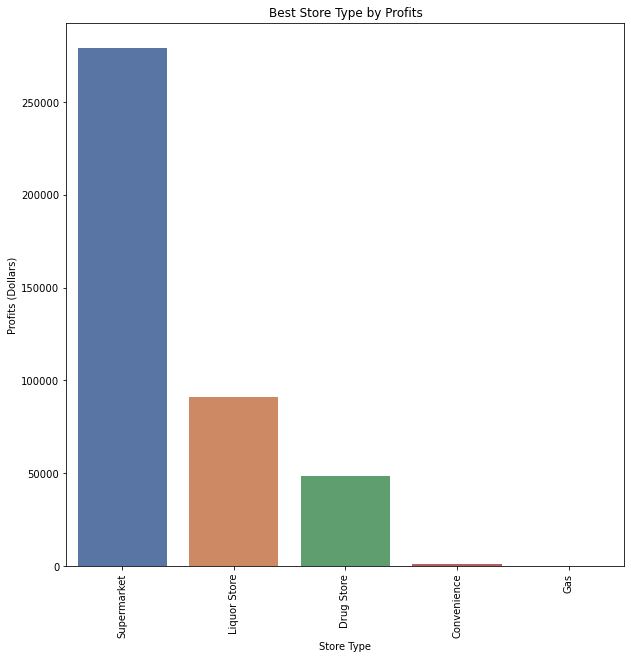

In [24]:
a1 = (10, 10)
fig, ax = plt.subplots(figsize=a1)
plot= sns.barplot(x="Store Type", y="Profit_per_sale", data=tts,palette ="deep")
plot.set_xticklabels(ax.get_xticklabels(),rotation=90)
plot.set_title('Best Store Type by Profits')
ax.set_ylabel('Profits (Dollars)')
ax.set_xlabel('Store Type')

# Which liquor type are most profitable overall 

In [25]:
total_sale_liquor = df.groupby('LiquorType').agg({'Profit_per_sale':'sum'}).reset_index().sort_values('Profit_per_sale',ascending =False)
ttb = total_sale_liquor.head(10)
ttb

LiquorType  Profit_per_sale
13  whisky/bourbon/scotch    123493.811625
12                  vodka    110102.300965
6                liqueurs     58622.129174
9                     rum     43212.668953
11                tequila     25195.310205
10               schnapps     15899.640130
5                     gin     13432.329875
3            cocktail mix      9167.410019
4                   gifts      8752.729945
2                  brandy      8314.650045

Text(0.5, 0, 'Liquor Type')

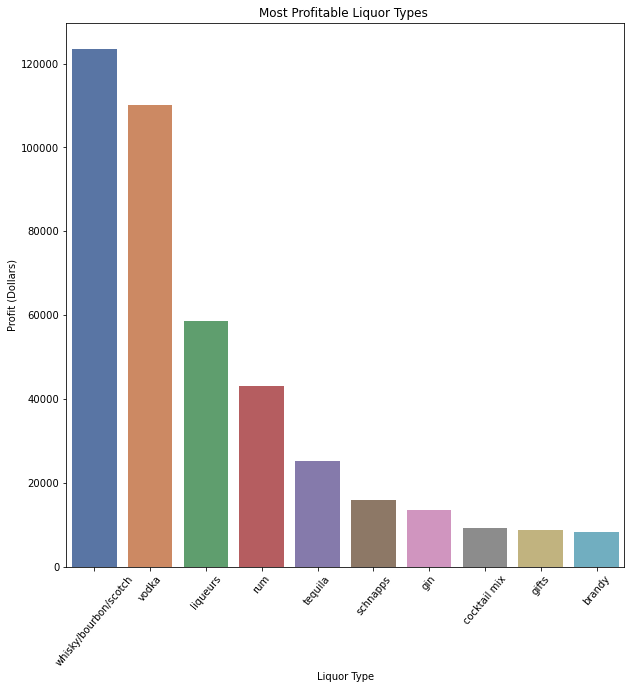

In [26]:

fig, ax = plt.subplots(figsize=(10,10))
plot= sns.barplot(x="LiquorType", y="Profit_per_sale", data=ttb,palette ="deep")
plot.set_xticklabels(ax.get_xticklabels(),rotation=50)
plot.set_title('Most Profitable Liquor Types ')
ax.set_ylabel('Profit (Dollars)')
ax.set_xlabel('Liquor Type')

# Exploring which categories of alcohol are more profitable on average

In [27]:
best10 = df.groupby(['category_name'])['Profit_per_bottle'].mean().groupby(['category_name']).max().sort_values().groupby(['category_name']).sum().sort_values(ascending=False).reset_index()

best10_plot = px.bar(best10.head(10),x=best10['category_name'].head(10), y='Profit_per_bottle',color='Profit_per_bottle')
best10_plot.update_layout(
    title="10 Best Average Profit per Bottle Liquor Categories",
    xaxis_title="Category Name",
    yaxis_title="Average Profit per Bottle($)")
best10_plot.show()

# Exploring which categories of alcohol are least profitable

In [29]:
low10_plot = px.bar(best10.tail(10),x=best10['category_name'].tail(10), y='Profit_per_bottle',color='Profit_per_bottle')
low10_plot.update_layout(
    title="10 Lowest Profit Liquor Categories",
    xaxis_title="Category Name",
    yaxis_title="Average Profit per Bottle($)")
low10_plot.show()

# Exploring which counties have the highest profits overall 

In [30]:
#turning the county names to lowercase to prevent discrepancies
df['county'] = df['county'].str.lower()

In [31]:
bestcounty = df.groupby(['county'])['Profit_per_sale'].sum().groupby(['county']).max().sort_values().groupby(['county']).sum().sort_values(ascending=False).reset_index()

bestcounty_plot = px.bar(bestcounty.head(10),x=bestcounty['county'].head(10), y='Profit_per_sale',color='Profit_per_sale')
bestcounty_plot.update_layout(
    title="10 Best County Profit Liquor",
    xaxis_title="county",
    yaxis_title="Total Profits ($)")
bestcounty_plot.show()

# Comparing sales profits by city

In [32]:
df['city'] = df['city'].str.lower()

In [33]:
bestcity = df.groupby(['city'])['Profit_per_sale'].sum().groupby(['city']).max().sort_values().groupby(['city']).sum().sort_values(ascending=False).reset_index()

bestcity_plot = px.bar(bestcity.head(10),x=bestcity['city'].head(10), y='Profit_per_sale',color='Profit_per_sale')
bestcity_plot.update_layout(
    title="10 Best City for Profit Liquor Categories",
    xaxis_title="City",
    yaxis_title="Total Profits ($)")
bestcity_plot.show()

# Finding Total Bottles Sold in each City

In [34]:
bottlecity = df.groupby(['city'])['bottles_sold'].sum().groupby(['city']).max().sort_values().groupby(['city']).sum().sort_values(ascending=False).reset_index()

bottlecity_plot = px.bar(bottlecity.head(10),x=bottlecity['city'].head(10), y='bottles_sold',color='bottles_sold')
bottlecity_plot.update_layout(
    title="10 Highest Bottles Sold by City",
    xaxis_title="City",
    yaxis_title="Total Bottles Sold")
bottlecity_plot.show()

# Comparing Vendors with the Highest Profits

In [35]:
df['vendor_name'] = df['vendor_name'].str.lower()

In [36]:
bestvendors = df.groupby(['vendor_name'])['Profit_per_sale'].sum().groupby(['vendor_name']).max().sort_values().groupby(['vendor_name']).sum().sort_values(ascending=False).reset_index()

bestvendors_plot = px.bar(bestvendors.head(10),x=bestvendors['vendor_name'].head(10), y='Profit_per_sale',color='Profit_per_sale')
bestvendors_plot.update_layout(
    title="10 Best Vendors for Profit Liquor Categories",
    xaxis_title="Vendor",
    yaxis_title="Total Profits ($)")
bestvendors_plot.show()

In [37]:

#df['city'].value_counts().head(20)
df.groupby(['city'])['store_name'].value_counts()

city             store_name                               
albia            hy-vee food store / albia                     27
algona           hy-vee wine and spirits / algona              56
altoona          hy-vee food store / altoona                  105
ames             hy-vee  #2 / ames                             51
                 hy-vee drugstore #2 / ames                    13
                 hy-vee wine and spirits / ames                 3
                 hy-vee gase #5018 / ames                       1
ankeny           hy-vee food store #2 / state ankeny           60
                 hy-vee #2 / ankeny                            50
                 hy-vee #2                                      1
                 hy-vee gas #1 / ankeny                         1
atlantic         hy-vee wine and spirits / atlantic            61
bedford          hy-vee food store / bedford                   12
bettendorf       hy-vee wine and spirits / bettendorf         170
boone            

In [38]:
#finding the most commonly purchased category
df['category_name'].mode()

0    canadian whiskies
dtype: object

In [ ]:
#finding the most common vendor in the dataset
df['vendor_name'].mode()

# Looking at the sales for each store location

In [ ]:
store_sales= df.groupby('store_name').sale_dollars.sum().groupby(['store_name']).max().sort_values().groupby(['store_name']).sum().sort_values(ascending=False).reset_index()
store_sales_plot = px.bar(store_sales.head(10),x=store_sales['store_name'].head(10), y='sale_dollars',color='sale_dollars')
store_sales_plot.update_layout(
    title="10 Highest Sales Stores",
    xaxis_title="Store Number",
    yaxis_title="Total Sales($)")
store_sales_plot.show()

# Checking if the stores with the highest sales also have the highest profits

In [ ]:
store_profit= df.groupby('store_name').Profit_per_sale.sum().groupby(['store_name']).max().sort_values().groupby(['store_name']).sum().sort_values(ascending=False).reset_index()
store_profit_plot = px.bar(store_profit.head(10),x=store_profit['store_name'].head(10), y='Profit_per_sale',color='Profit_per_sale')
store_profit_plot.update_layout(
    title="10 Highest Profit Stores",
    xaxis_title="Store Name",
    yaxis_title="Total Profits($)")
store_profit_plot.show()

# Looking at monthly profits for liquor types

# Creating a Heatmap of the locations of the liquor stores in Iowa

In [ ]:
#First we need to clean up the store location column
# df1=df
# df1 = df1[df1['store_location'].notna()]


In [39]:
#Changing the column type to string so we can strip leading POINT
df['store_location'] = df.store_location.astype(str)

#stripping the non-latitude-longitude values from the column
df['store_location'] = df['store_location'].map(lambda x: x.lstrip('POINT (').rstrip(')'))


In [40]:
#creating latitude and longitude columns to use for our heatmap
df[['Longitude','Latitude']] = df['store_location'].str.split(' ', expand=True)


In [41]:
#folium requires the data to be float type

df['Latitude'] = df['Latitude'].str.replace(' ', '').astype(float)
df['Longitude'] = df['Longitude'].str.replace(' ', '').astype(float)

#dropping the original store location column since now it is repetitive
df = df.drop('store_location', 1)

In [42]:
df.head()

date store_number                          store_name  \
0  2017-01-17         2647            hy-vee #7 / cedar rapids   
1  2016-02-09         2606  hy-vee wine and spirits / humboldt   
2  2021-05-22         2710             hy-vee gas #1 / ottumwa   
3  2014-04-07         2521  hy-vee food and drug / grand / wdm   
4  2019-01-31         2675              hy-vee #2 / coralville   

               address             city zip_code    county  \
0     5050 Edgewood Rd     cedar rapids    52411      linn   
1  1011  13TH ST NORTH         humboldt    50548  humboldt   
2    1027 N Quincy Ave          ottumwa  52501.0   wapello   
3    1990 GRAND AVENUE  west des moines    50265      polk   
4    3285 Crosspark Rd       coralville  52241.0   johnson   

               category_name vendor_number                     vendor_name  \
0           blended whiskies         434.0                       luxco inc   
1             vodka 80 proof           434                  luxco-st louis   
2            american vodkas           626  jdso inc / red boot distillery   
3          imported dry gins           260                 diageo americas   
4  straight bourbon whiskies          65.0                 jim beam brands   

            item_description  pack  state_bottle_cost  state_bottle_retail  \
0      Hawkeye Blend Whiskey     6               7.62                11.43   
1              Hawkeye Vodka     6               7.17                10.76   
2              Blue Ox Vodka     6               7.17                10.76   
3              Tanqueray Gin    12              12.00                17.99   
4  Makers Mark Cask Strength     6              31.50                47.25   

   bottles_sold  sale_dollars  volume_sold_liters  Profit_per_bottle  \
0             6     68.580002               10.50               3.81   
1             6     64.559998               10.50               3.59   
2             1     10.760000                1.75               3.59   
3            12    215.880005                9.00               5.99   
4             6    283.440002                4.50              15.75   

   Profit_per_sale    Store Type             LiquorType Bottle Size  \
0        22.860003   Supermarket  whisky/bourbon/scotch         750   
1        21.540001  Liquor Store                  vodka         750   
2         3.590000           Gas                  vodka         750   
3        71.879997    Drug Store                    gin         750   
4        94.500000   Supermarket  whisky/bourbon/scotch         750   

   Longitude   Latitude  
0 -91.701581  42.030129  
1 -94.227116  42.733221  
2 -92.438465  41.016113  
3 -93.731620  41.571127  
4 -91.606271  41.721438

In [43]:
import folium
from IPython.display import display

mymap= folium.Map(location=[43.088341,-93.990256], zoom_start=8, )

hm_wide = HeatMap(
    list(zip(df.Latitude.values, df.Longitude.values)),
    min_opacity=0.3,
    radius=10, 
    blur=9, 
    max_zoom=1,
)
mymap.add_child(hm_wide)
#mymap.add_child(folium.ClickForMarker(popup='Potential Location'))

In [ ]:
df

# Looking at time series data 

In [28]:
from dateutil.parser import parse 

In [29]:
#making a new dataframe I can make changes to
timedf=df
#converting date column to datetime
timedf['date'] = pd.to_datetime(timedf['date'])
timedf['day_name'] = timedf['date'].dt.day_name()

In [30]:
timedf.head()

date store_number                           store_name  \
0 2019-10-11         2606   hy-vee wine and spirits / humboldt   
1 2015-03-17         2552  hy-vee food store #3 / cedar rapids   
2 2020-04-27         2616       hy-vee food and drug / clinton   
4 2020-06-16         2544     hy-vee food store / marshalltown   
5 2013-06-15         2651                     hy-vee / waverly   

                 address          city zip_code  \
0    1011  13th St North      Humboldt    50548   
1  20 WILSON AVENUE WEST  CEDAR RAPIDS    52404   
2       901 South 4th St       Clinton  52732.0   
4       802 South Center  Marshalltown    50158   
5       1311 4 STREET SW       WAVERLY    50677   

                          store_location    county       category_name  \
0           POINT (-94.227116 42.733221)  HUMBOLDT       mixto tequila   
1           POINT (-91.658577 41.955859)      Linn         jamaica rum   
2  POINT (-90.193204 41.836268000000004)   CLINTON          triple sec   
4           POINT (-92.912817 42.039205)  MARSHALL   american schnapps   
5           POINT (-92.475403 42.712263)    Bremer  single malt scotch   

  vendor_number              vendor_name  \
0         434.0                LUXCO INC   
1           260          Diageo Americas   
2            65          Jim Beam Brands   
4            55    SAZERAC NORTH AMERICA   
5           420  Moet Hennessy USA, Inc.   

                        item_description  pack  state_bottle_cost  \
0                            Juarez Gold    12               7.83   
1              Myers's Rum Original Dark    12              12.50   
2                    Dekuyper Triple Sec    12               2.33   
4                      99 Root Beer Mini    10               6.00   
5  Glenmorangie 10 Yr Single Malt Scotch     6              21.49   

   state_bottle_retail  bottles_sold  sale_dollars  volume_sold_liters  \
0            11.750000            24    282.000000                24.0   
1            18.750000             3     56.250000                 3.0   
2             3.500000            72    252.000000                72.0   
4             9.000000            10     90.000000                 0.5   
5            32.240002             2     64.480003                 1.5   

   Profit_per_bottle  Profit_per_sale    Store Type             LiquorType  \
0           3.920000        94.080002  Liquor Store                tequila   
1           6.250000        18.750000   Supermarket                    rum   
2           1.170000        84.240005    Drug Store               liqueurs   
4           3.000000        30.000000   Supermarket               schnapps   
5          10.750002        21.500004   Supermarket  whisky/bourbon/scotch   

  Bottle Size  day_name  
0        1000    Friday  
1        1000   Tuesday  
2        1000    Monday  
4           c   Tuesday  
5         750  Saturday

In [31]:
#finding the total sales profits each day
#dailyprofits = timedf.groupby([timedf.date.dt.dayofyear])['Profit_per_sale'].sum().reset_index()
dailyprofits = timedf.groupby(['date'])['Profit_per_sale'].sum().reset_index()

#rename sum of profit per sale to profit per day
dailyprofits.rename({'Profit_per_sale': 'Profit_per_day'}, axis=1, inplace=True)
dailyprofits.head()

date  Profit_per_day
0 2012-01-03      125.639992
1 2012-01-04       96.570003
2 2012-01-05       95.329991
3 2012-01-09      105.610004
4 2012-01-10      109.689997

In [32]:
#finding which day had the highest profit sales
print("Max profits:", dailyprofits.loc[dailyprofits['Profit_per_day'] == dailyprofits['Profit_per_day'].max()])

#finding the day with the lowest profit sales
print("Min profits:",dailyprofits.loc[dailyprofits['Profit_per_day'] == dailyprofits['Profit_per_day'].min()])

Max profits:          date  Profit_per_day
66 2012-04-30    10771.778678
Min profits:            date  Profit_per_day
1741 2019-11-30             2.0


Text(0.5, 1.0, 'Profit per Day')

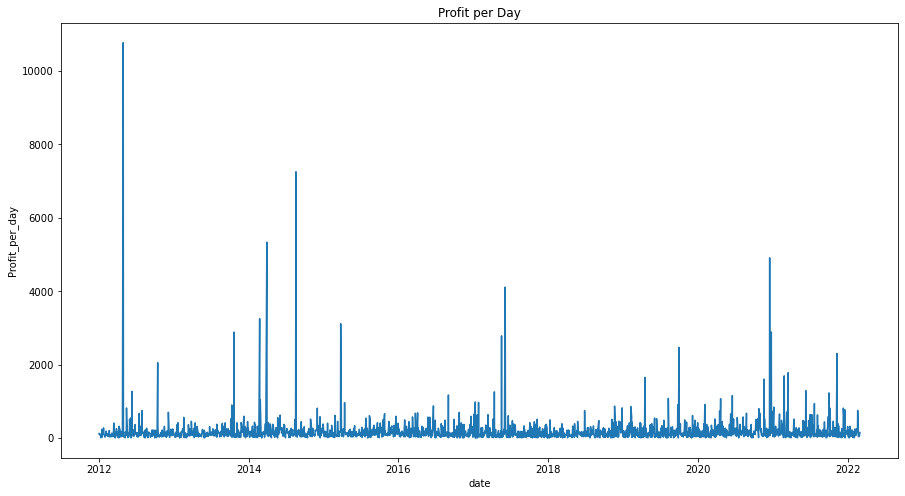

In [33]:
y=dailyprofits['Profit_per_day']
x=dailyprofits['date']
plt.figure(figsize=(15,8))
sns.lineplot(x,y)
plt.title('Profit per Day')

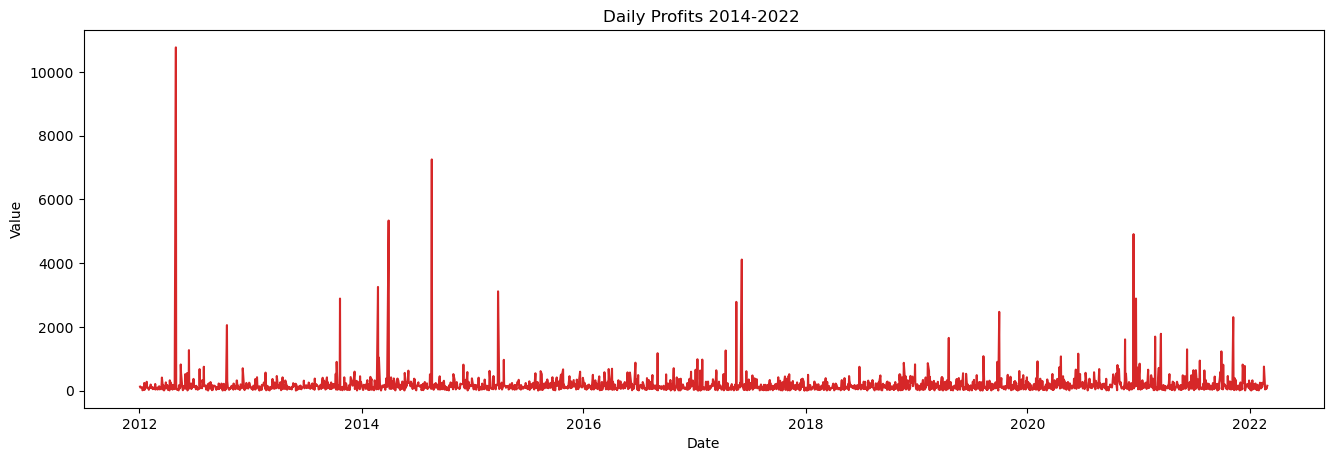

In [34]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(dailyprofits, x=dailyprofits.date, y=dailyprofits.Profit_per_day, title='Daily Profits 2014-2022 ')    

# Looking at bottles sold per day

In [35]:

#creating a dataframe of the total bottles sold per day
dailybottles=timedf.groupby(['date'])['bottles_sold'].sum().reset_index()

#dailysales = dailysales.set_index('date')

#rename sum of profit per sale to profit per day
dailybottles.rename({'bottles_sold': 'daily_bottles_sold'}, axis=1, inplace=True)

#converting the date to datetime format
#dailybottles['date']=pd.to_datetime(dailybottles['date'])
dailybottles.head()

date  daily_bottles_sold
0 2012-01-03                  36
1 2012-01-04                  25
2 2012-01-05                  27
3 2012-01-09                  17
4 2012-01-10                  23

Text(0.5, 1.0, 'Bottles Sold Per Day')

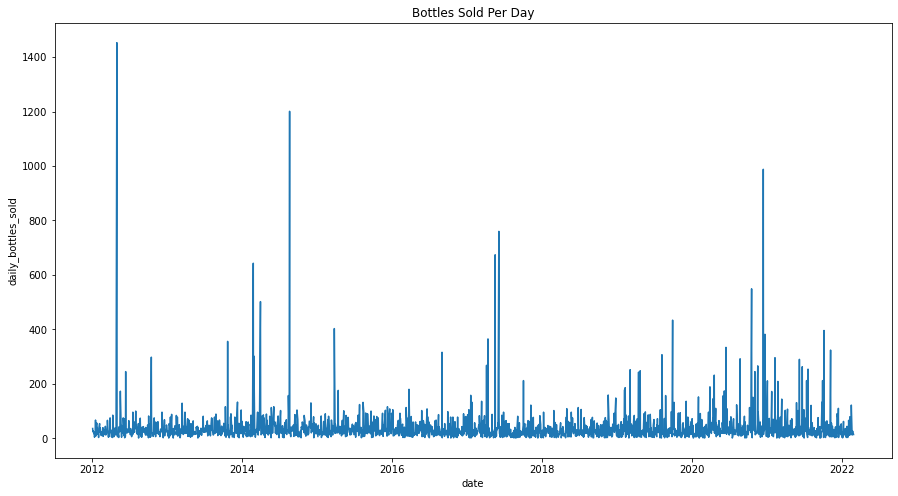

In [36]:
#plotting the bottles sold per day
y=dailybottles['daily_bottles_sold']
x=dailybottles['date']
plt.figure(figsize=(15,8))
sns.lineplot(x,y)
plt.title('Bottles Sold Per Day')

Text(0.5, 1.0, 'Daily Bottles Sold')

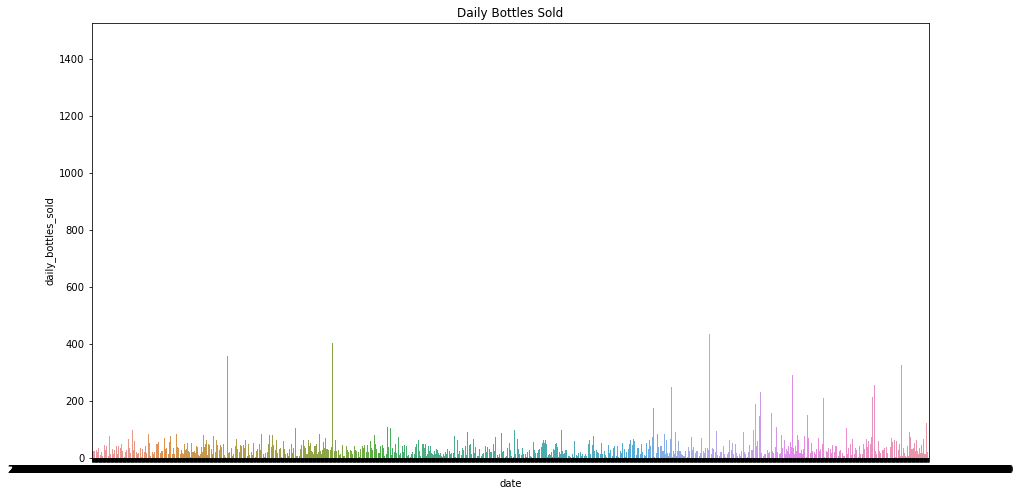

In [37]:
plt.figure(figsize=(15,8))
sns.barplot(x,y)
plt.title('Daily Bottles Sold')

# Comparing weekly sales

In [38]:
#making a new df to experiment with without ruining original
df2=df

#converting date column to datetime
df2['date'] = pd.to_datetime(df2['date'])

Text(0.5, 1.0, 'Bottles Sold Each Week')

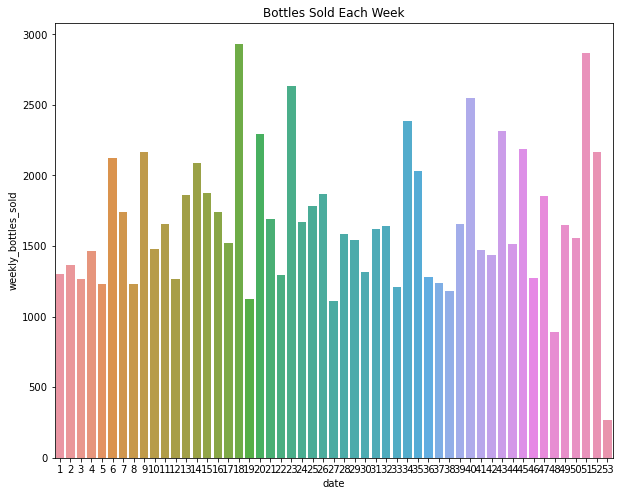

In [39]:
#finding the amount of bottles of liquor sold each week
weekly = df2.groupby(df2.date.dt.weekofyear)['bottles_sold'].agg('sum').reset_index()

#rename sum of bottles sold to weekly bottles sold
weekly.rename({'bottles_sold': 'weekly_bottles_sold'}, axis=1, inplace=True)

#plotting 
x1=weekly['date']
y1=weekly['weekly_bottles_sold']
plt.figure(figsize=(10,8))
sns.barplot(x1,y1)
plt.title('Bottles Sold Each Week')

<AxesSubplot:xlabel='date', ylabel='weekly_bottles_sold'>

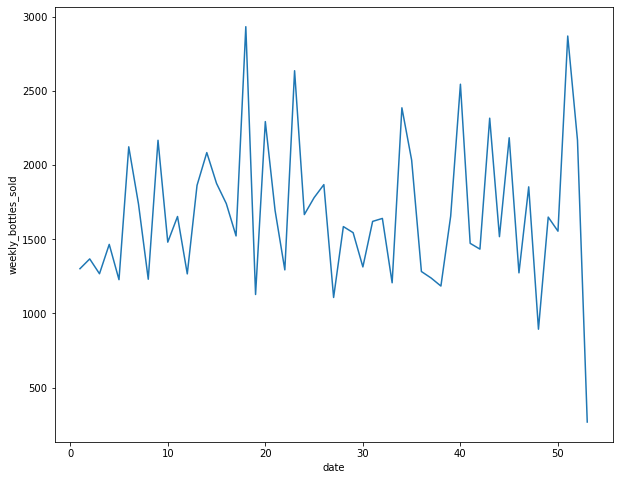

In [40]:
#lineplot of the weekly bottle sales
plt.figure(figsize=(10,8))
sns.lineplot(x1,y1)

Text(0.5, 1.0, 'Weekly Profit Each Week')

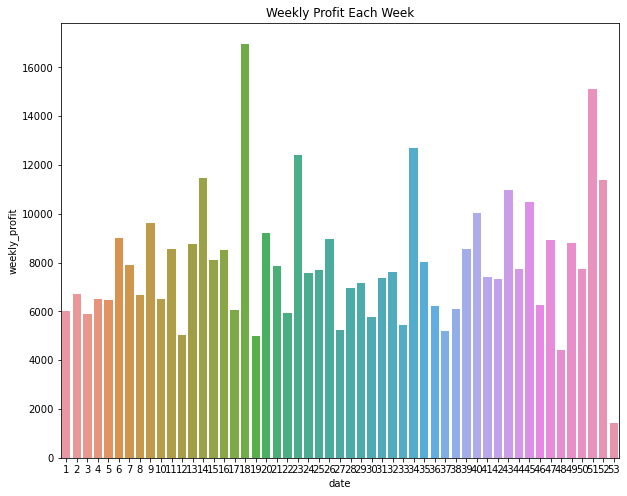

In [41]:
#finding the profit each week
weekly = df2.groupby(df2.date.dt.weekofyear)['Profit_per_sale'].agg('sum').reset_index()


#rename sum of bottles sold to weekly bottles sold
weekly.rename({'Profit_per_sale': 'weekly_profit'}, axis=1, inplace=True)

#plotting the profits by week
xw=weekly['date']
yw=weekly['weekly_profit']
plt.figure(figsize=(10,8))
sns.barplot(xw,yw)
plt.title('Weekly Profit Each Week')

<AxesSubplot:xlabel='date', ylabel='weekly_profit'>

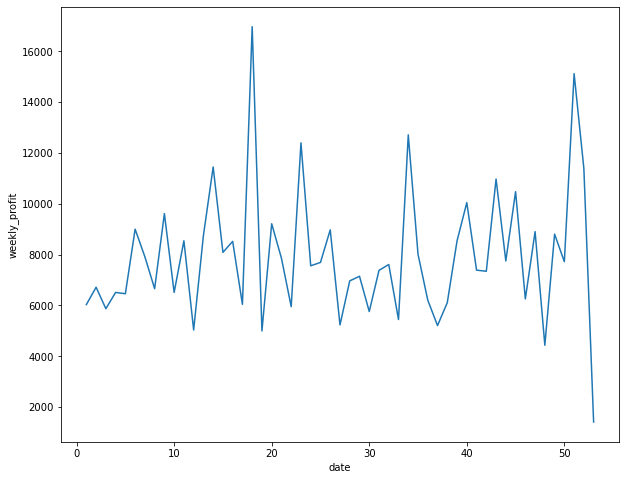

In [42]:
plt.figure(figsize=(10,8))
sns.lineplot(xw,yw)

<AxesSubplot:xlabel='date'>

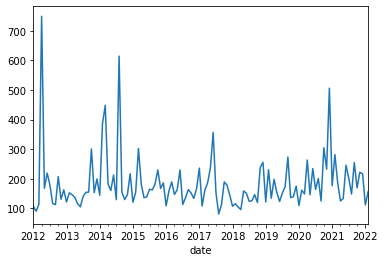

In [43]:
y = df.groupby('date')['Profit_per_sale'].sum().resample('MS').mean()
y.plot()

# Looking at months overall for seasonal patterns

Text(0.5, 1.0, 'Bottles Sold Each Month')

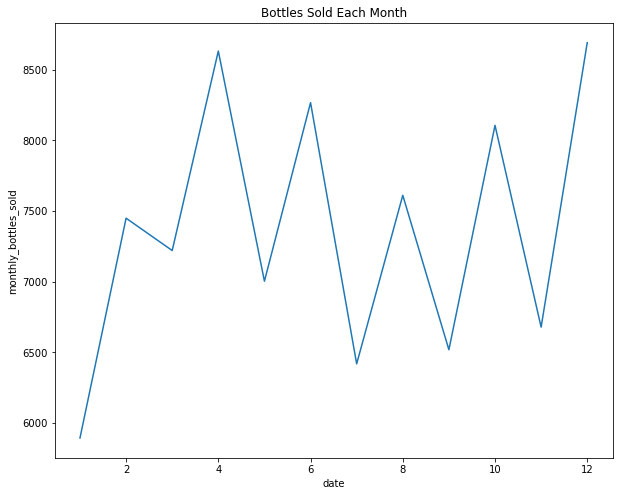

In [44]:
#finding the amount of bottles of liquor sold each month
monthly = df2.groupby(df2.date.dt.month)['bottles_sold'].agg('sum').reset_index()

#rename sum of bottles sold to monthly bottles sold
monthly.rename({'bottles_sold': 'monthly_bottles_sold'}, axis=1, inplace=True)

#plotting 
x1=monthly['date']
y1=monthly['monthly_bottles_sold']
plt.figure(figsize=(10,8))
sns.lineplot(x1,y1)
plt.title('Bottles Sold Each Month')

# Looking at months by year for overall trends

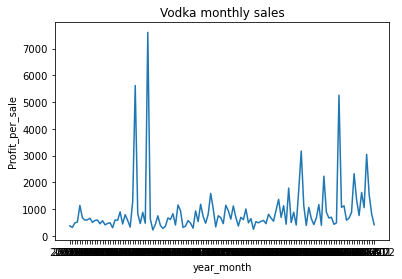

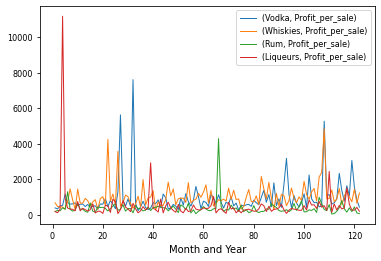

In [50]:
vodka = timedf[timedf['LiquorType'] == 'vodka'].groupby('year_month', as_index=False)['Profit_per_sale'].sum()
#print(vodka)

vodx=vodka['year_month']
vody=vodka['Profit_per_sale']

sns.lineplot(vodx,vody,data=vodka)
#plt.axhline(vodka['Profit_per_sale'].mean(),color="k",linestyle="dotted",linewidth=2)

plt.title('Vodka monthly sales') 

whisk = timedf[timedf['LiquorType'] == 'whisky/bourbon/scotch'].groupby('year_month', as_index=False)['Profit_per_sale'].sum()
whisky=whisk['Profit_per_sale']

rum = timedf[timedf['LiquorType'] == 'rum'].groupby('year_month', as_index=False)['Profit_per_sale'].sum()
rumy=rum['Profit_per_sale']

liqueurs = timedf[timedf['LiquorType'] == 'liqueurs'].groupby('year_month', as_index=False)['Profit_per_sale'].sum()
rumy=rum['Profit_per_sale']

top4=[vody, whisky, rumy, liqueurs]
headers = ["Vodka","Whiskies","Rum", "Liqueurs"]

top4_sell = pd.concat(top4, axis=1, keys=headers)
top4_sell.index = top4_sell.index +1

import matplotlib.ticker as ticker

ax = top4_sell.plot(linewidth=1, fontsize=8);
ax.set_xlabel('Month and Year');
ax.legend(fontsize=8)
ax.xaxis.set_major_locator(ticker.MultipleLocator(20));

In [46]:
timedf['year_month'] = timedf['date'].dt.strftime('%Y-%m')

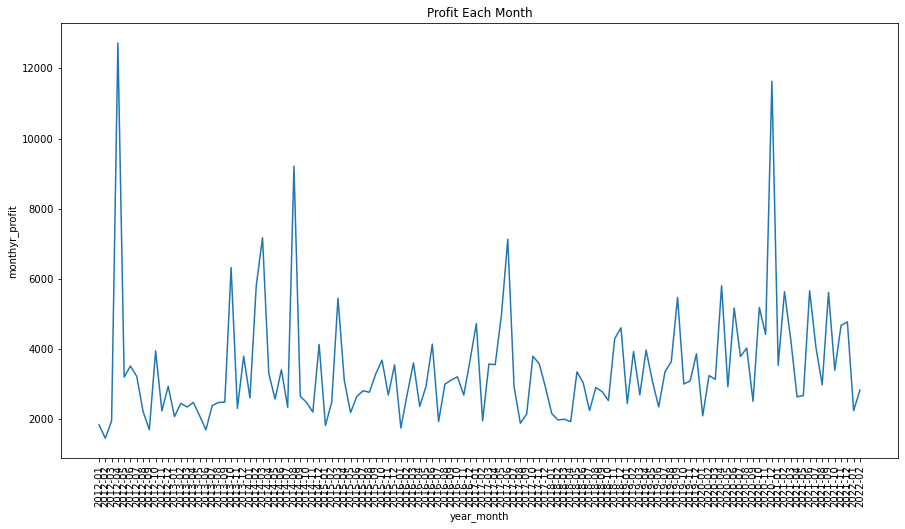

In [47]:
#finding the amount of bottles of liquor sold each month
monthyr = timedf.groupby(timedf['year_month'])['Profit_per_sale'].agg('sum').reset_index()

#rename sum of bottles sold to monthly bottles sold
monthyr.rename({'Profit_per_sale': 'monthyr_profit'}, axis=1, inplace=True)

#plotting 
xm=monthyr['year_month']
ym=monthyr['monthyr_profit']
plt.figure(figsize=(15,8))
sns.lineplot(xm,ym)
plt.title('Profit Each Month')
plt.xticks(rotation=90);


In [52]:
monthyr.set_index('year_month', inplace=True)
monthyr

monthyr_profit
year_month                
2012-01        1832.459968
2012-02        1452.339980
2012-03        1947.249937
2012-04       12727.878645
2012-05        3196.180013
2012-06        3513.340117
2012-07        3215.250101
2012-08        2217.199924
2012-09        1697.469976
2012-10        3944.119901
2012-11        2231.929950
2012-12        2935.629969
2013-01        2069.839957
2013-02        2447.709971
2013-03        2343.500016
2013-04        2474.670041
2013-05        2094.250048
2013-06        1692.150013
2013-07        2388.700030
2013-08        2472.509988
2013-09        2485.340088
2013-10        6319.470254
2013-11        2303.189981
2013-12        3793.540035
2014-01        2603.180042
2014-02        5798.070210
2014-03        7173.869669
2014-04        3293.549986
2014-05        2569.770056
2014-06        3405.340033
2014-07        2332.629955
2014-08        9212.741023
2014-09        2653.130010
2014-10        2472.699981
2014-11        2198.380018
2014-12        4128.570048
2015-01        1817.379970
2015-02        2481.320069
2015-03        5444.050007
2015-04        3104.340098
2015-05        2184.050039
2015-06        2646.309998
2015-07        2805.580038
2015-08        2764.639967
2015-09        3286.919980
2015-10        3680.730015
2015-11        2683.739975
2015-12        3546.480083
2016-01        1744.790008
2016-02        2700.970031
2016-03        3602.240032
2016-04        2361.499925
2016-05        2934.349985
2016-06        4138.040016
2016-07        1928.010009
2016-08        2994.829990
2016-09        3111.520095
2016-10        3204.700078
2016-11        2682.140090
2016-12        3674.919987
2017-01        4723.170043
2017-02        1951.289973
2017-03        3568.730070
2017-04        3551.320118
2017-05        4979.030036
2017-06        7130.279469
2017-07        2925.980022
2017-08        1879.309981
2017-09        2141.659987
2017-10        3792.230068
2017-11        3576.460122
2017-12        2900.590077
2018-01        2153.530038
2018-02        1972.630029
2018-03        1995.460008
2018-04        1925.610041
2018-05        3345.790004
2018-06        3030.950042
2018-07        2241.210049
2018-08        2899.040021
2018-09        2783.499973
2018-10        2527.320027
2018-11        4289.720155
2018-12        4604.480077
2019-01        2444.620017
2019-02        3923.969968
2019-03        2689.970023
2019-04        3970.739896
2019-05        3080.430017
2019-06        2348.769998
2019-07        3346.310061
2019-08        3638.000043
2019-09        5470.030009
2019-10        2999.550002
2019-11        3084.270105
2019-12        3862.879979
2020-01        2091.769993
2020-02        3238.809879
2020-03        3132.560032
2020-04        5799.109976
2020-05        2921.970026
2020-06        5167.530046
2020-07        3782.740028
2020-08        4024.279968
2020-09        2505.500003
2020-10        5184.100068
2020-11        4415.489933
2020-12       11637.349673
2021-01        3533.780051
2021-02        5632.750021
2021-03        4269.940052
2021-04        2634.530047
2021-05        2671.200033
2021-06        5660.330112
2021-07        4048.270023
2021-08        2975.710101
2021-09        5614.290076
2021-10        3390.140021
2021-11        4669.739756
2021-12        4770.600014
2022-01        2241.270001
2022-02        2825.960042

In [53]:
from statsmodels.tsa.stattools import adfuller, kpss

In [54]:
# ADF Test
result = adfuller(monthyr.monthyr_profit.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

#  if P-Value in ADH test is less than the significance level (0.05), you reject the null 
# hypothesis that the data is non-stationary. 
#we get pvalue which is more that 0.05
# meaning that the null is accepted and the data is non-stationary
    
    
# KPSS Test
result = kpss(monthyr.monthyr_profit.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    


ADF Statistic: -10.575410156595693
p-value: 7.126777254101981e-19
Critial Values:
   1%, -3.485585145896754
Critial Values:
   5%, -2.885738566292665
Critial Values:
   10%, -2.5796759080663887

KPSS Statistic: 0.365546
p-value: 0.092006
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


Text(0.5, 1.0, 'Liquor Sales detrended by subtracting the least squares fit')

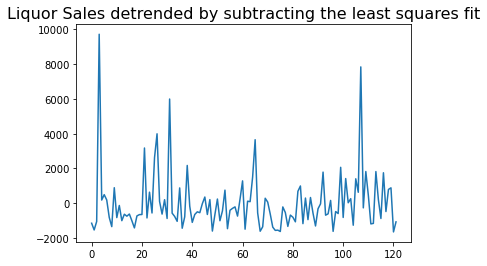

In [55]:
#Detrending a time series is to remove the trend component from a time series

# Using scipy: Subtract the line of best fit
from scipy import signal
detrended = signal.detrend(monthyr.monthyr_profit.values)
plt.plot(detrended)
plt.title('Liquor Sales detrended by subtracting the least squares fit', fontsize=16)


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

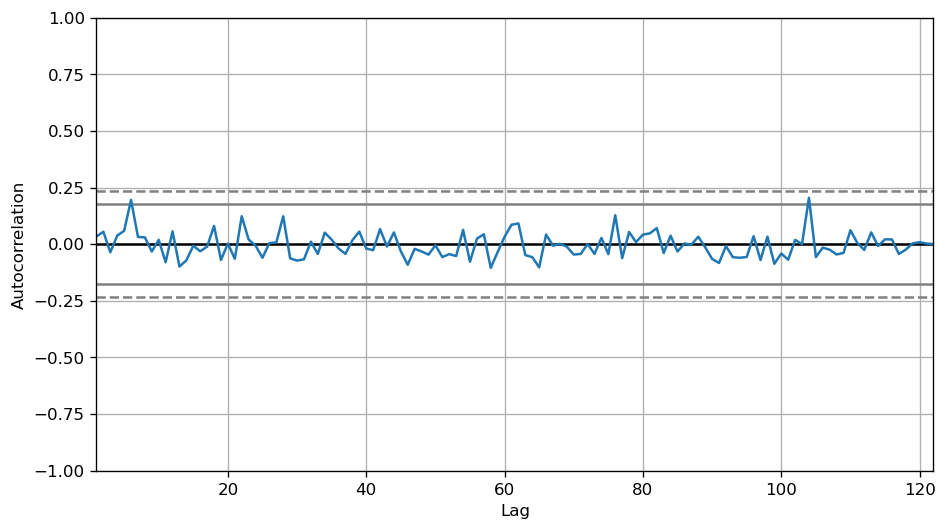

In [56]:
# when there is a strong seasonal pattern, the ACF plot usually reveals 
# definitive repeated spikes at the multiples of the seasonal window. 

from pandas.plotting import autocorrelation_plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(monthyr.monthyr_profit.tolist())

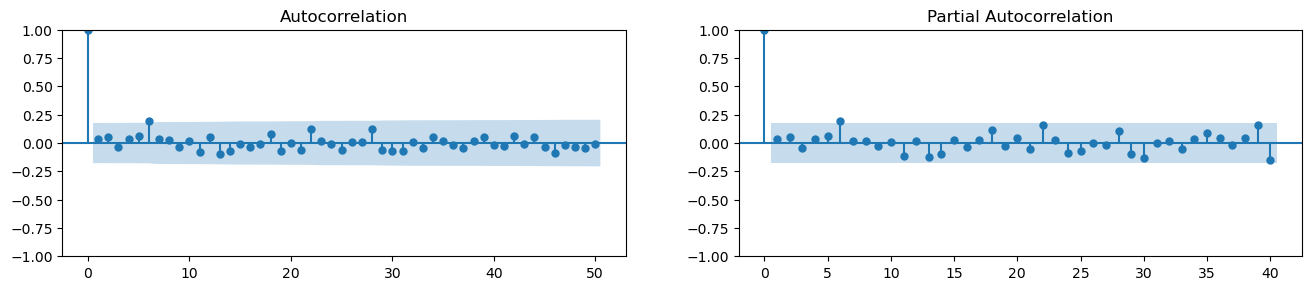

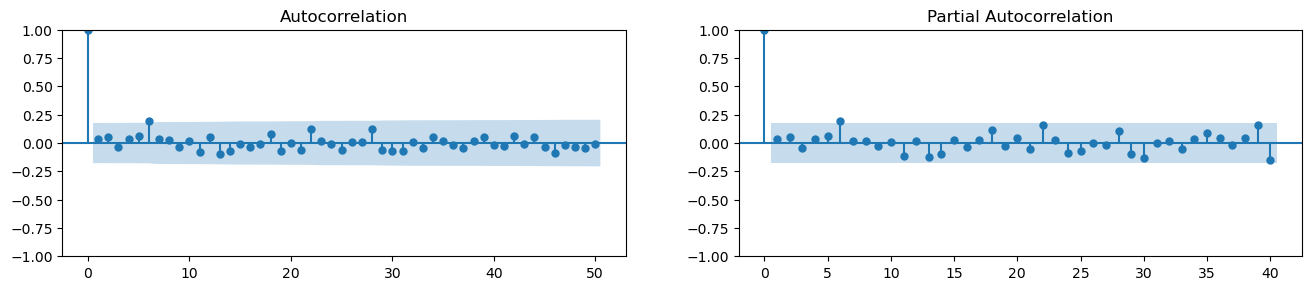

In [57]:
# If a series is significantly autocorrelated, that means, the previous values of the series (lags) 
# may be helpful in predicting the current value. Partial Autocorrelation also conveys similar 
# information but it conveys the pure correlation of a series and its lag, excluding the correlation 
# contributions from the intermediate lags.


from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(monthyr.monthyr_profit, nlags=50)
# pacf_50 = pacf(monthyr.monthyr_profit, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(monthyr.monthyr_profit.tolist(), lags=50, ax=axes[0])
plot_pacf(monthyr.monthyr_profit.tolist(), lags=40, ax=axes[1])

In [58]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# decompose_data = seasonal_decompose(monthyr, model="additive")
# decompose_data.plot();

# #Differencing the Timeseries data

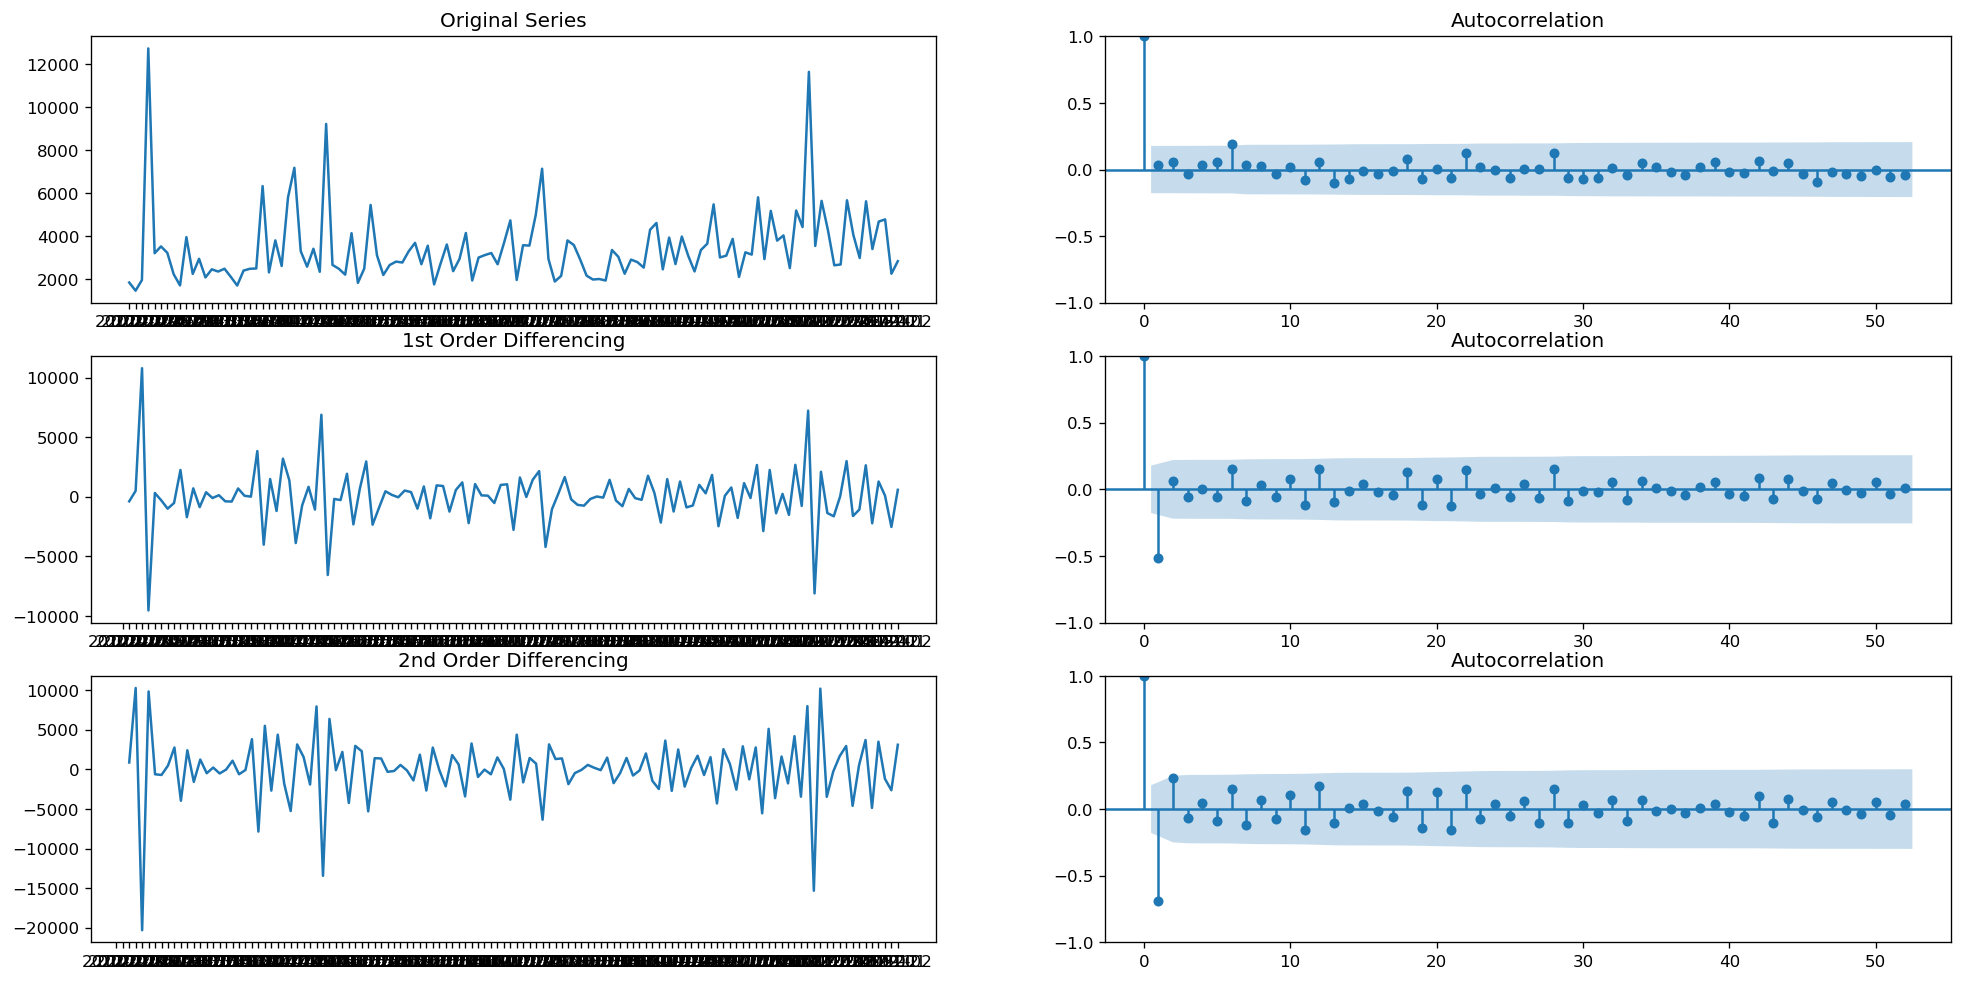

In [59]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(20,10))
axes[0, 0].plot(monthyr.monthyr_profit); axes[0, 0].set_title('Original Series')
plot_acf(monthyr.monthyr_profit, ax=axes[0, 1], lags=52)

# 1st Differencing
axes[1, 0].plot(monthyr.monthyr_profit.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(monthyr.monthyr_profit.diff().dropna(), ax=axes[1, 1], lags=52)

# 2nd Differencing
axes[2, 0].plot(monthyr.monthyr_profit.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(monthyr.monthyr_profit.diff().diff().dropna(), ax=axes[2, 1], lags=52)


plt.show()

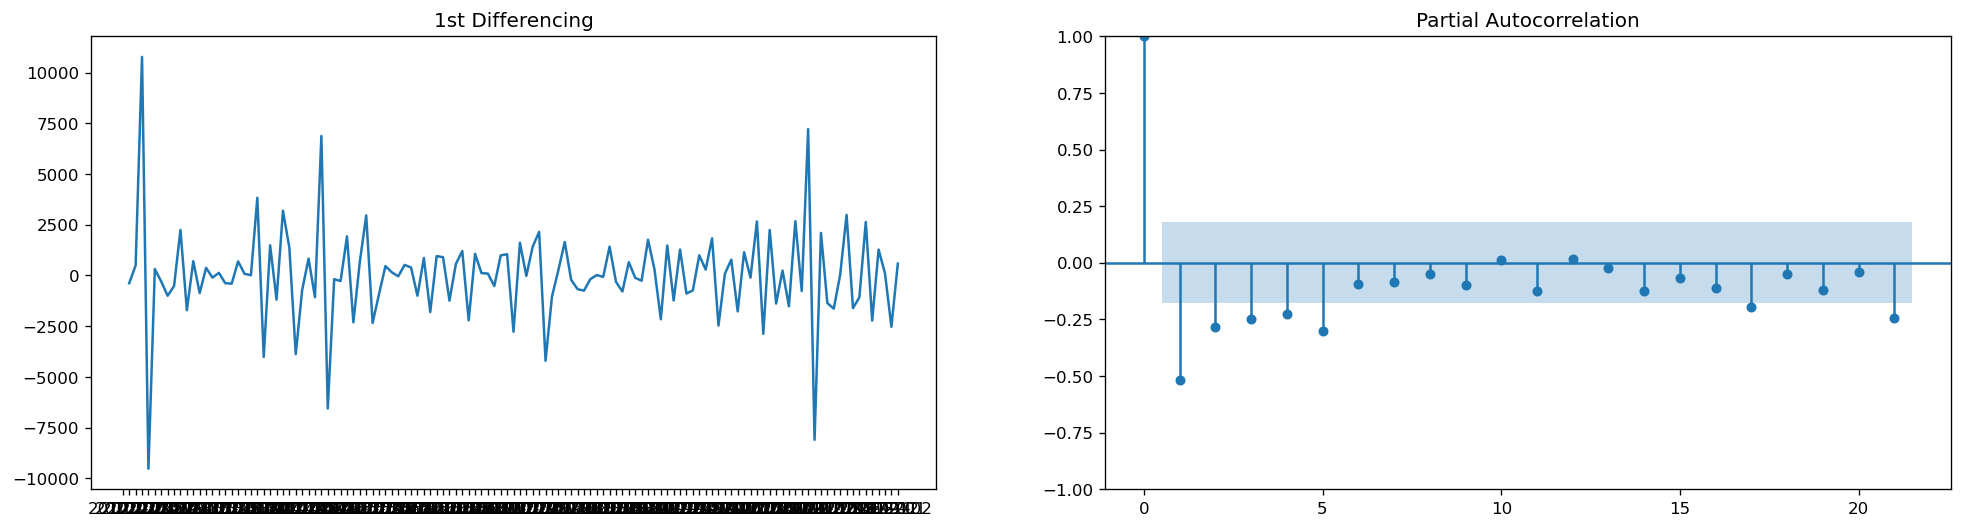

In [60]:
# PACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2, figsize=(20,5))
axes[0].plot(monthyr.monthyr_profit.diff()); axes[0].set_title('1st Differencing')
plot_pacf(monthyr.monthyr_profit.diff().dropna(), ax=axes[1])

plt.show()

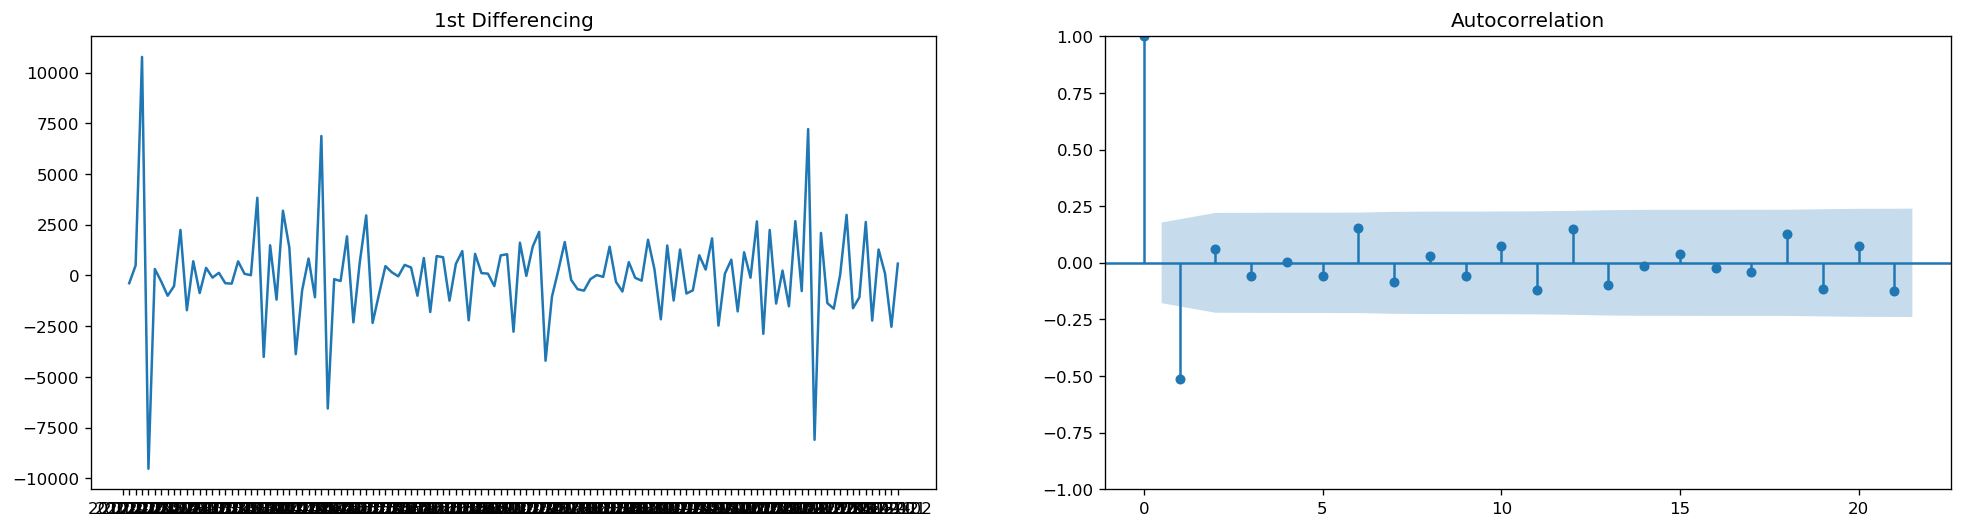

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
axes[0].plot(monthyr.monthyr_profit.diff()); axes[0].set_title('1st Differencing')
plot_acf(monthyr.monthyr_profit.diff().dropna(), ax=axes[1])
plt.show()

In [64]:
#p= 5 based on PACF, d=1 differencing once, q=1 from autocorrelation plot
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(monthyr.monthyr_profit.diff().dropna(),
              order=(5,1,1))
model_fit = model.fit()  #model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                               SARIMAX Results                                
Dep. Variable:         monthyr_profit   No. Observations:                  121
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -1069.514
Date:                Sat, 26 Mar 2022   AIC                           2153.028
Time:                        17:40:12   BIC                           2172.540
Sample:                    02-01-2012   HQIC                          2160.952
                         - 02-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8702      0.062    -13.991      0.000      -0.992      -0.748
ar.L2         -0.7034      0.102     -6.919      0.000      -0.903      -0.504
ar.L3         -0.6377      0.100     -6.382      0.0

/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



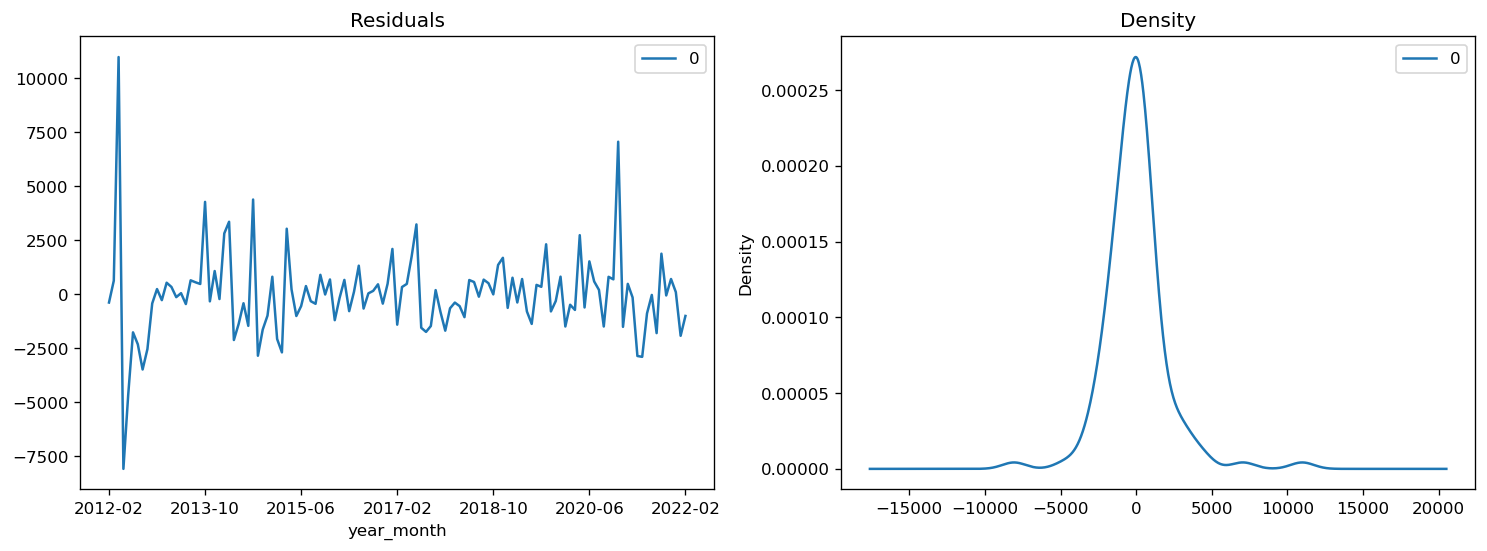

In [65]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Text(0, 0.5, 'Sale Profits')

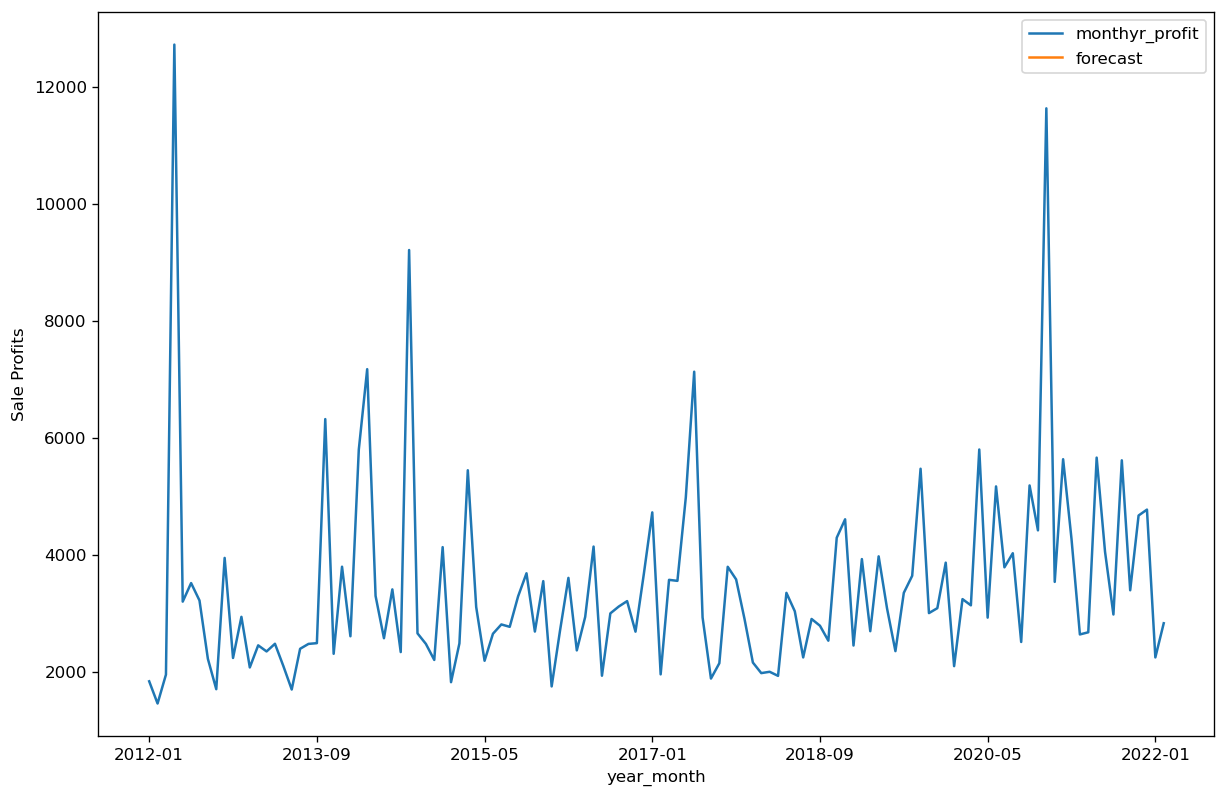

In [66]:
# Actual vs Fitted
monthyr['forecast']=model_fit.predict(start=90, end=103, dynamic=True)
monthyr[['monthyr_profit','forecast']].plot(figsize=(12,8))


# model_fit.plot_predict(dynamic=True)
plt.ylabel('Sale Profits')

<AxesSubplot:>

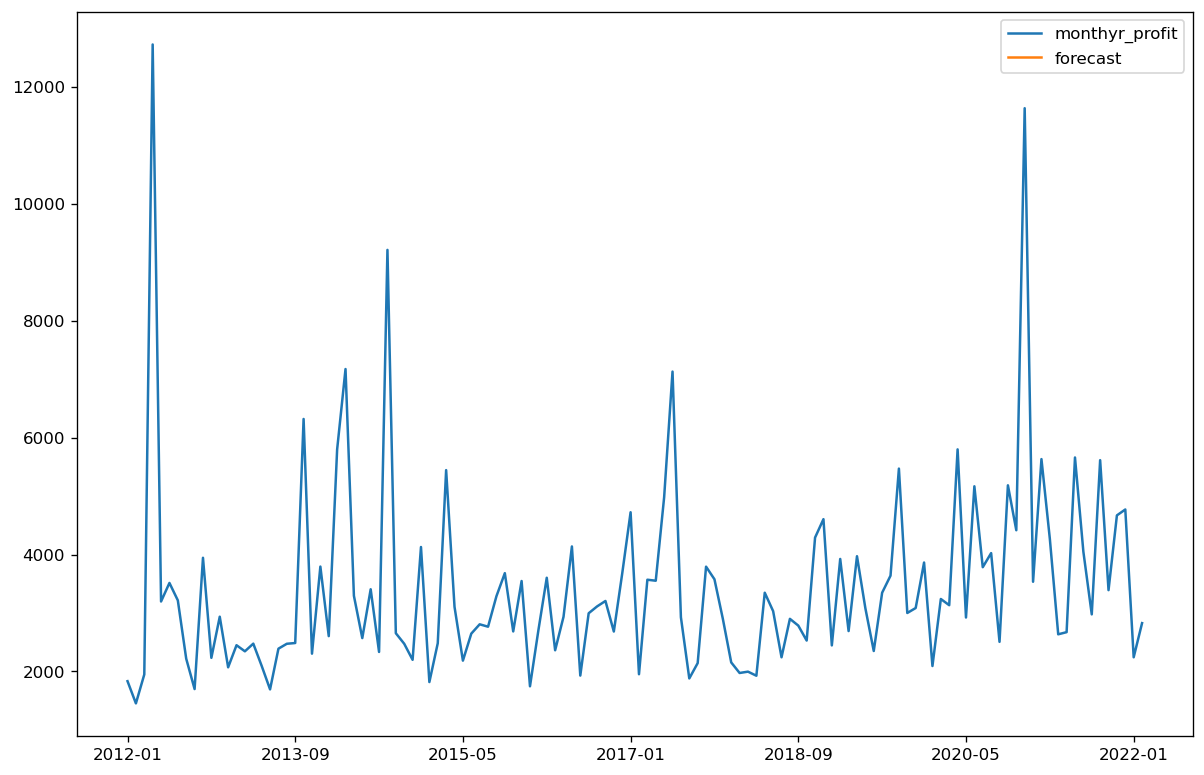

In [67]:
#another way to plot actual vs predicted that hopefully shows forecast
from pandas.tseries.offsets import DateOffset
pred_date=[monthyr.index[-1]+ str(DateOffset(months=x)for x in range(0,24))]
# Giving similar names to columns.

# Input:

pred_date=pd.DataFrame(index=pred_date[1:],columns=monthyr.columns)
pred_date

monthyr=pd.concat([monthyr,pred_date])
monthyr['forecast'] = model_fit.predict(start = 104, end = 120, dynamic= True)  
monthyr[['monthyr_profit', 'forecast']].plot(figsize=(12, 8))

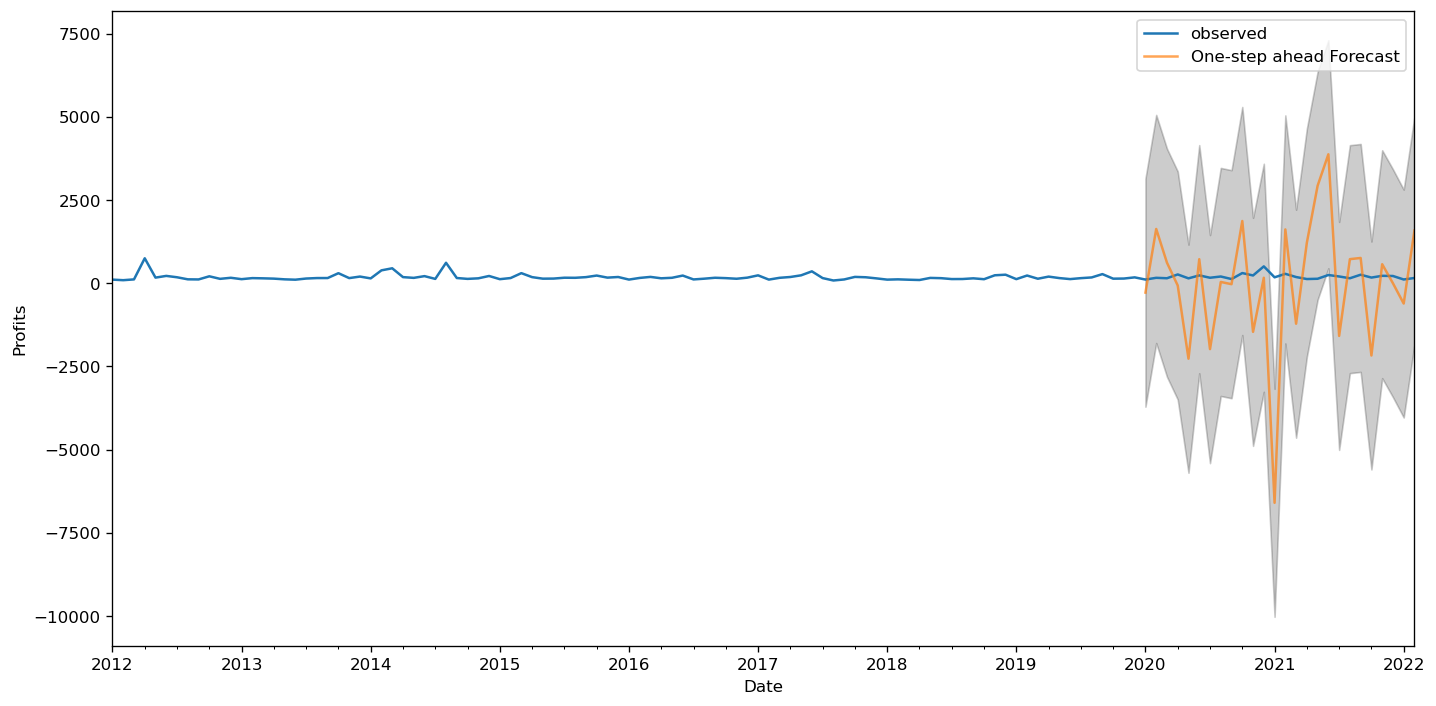

In [70]:
#pred = model_fit.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)

#update your data with the real values instead, you set dynamic=False
pred = model_fit.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Profits')
plt.legend()
plt.show()

In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# model = SARIMAX(monthyr.monthyr_profit.diff().dropna(),order=(5,1,1), exogeneous=monthyr.index,
#               seasonal_order=(5,1,1,12),enforce_stationarity=True,
#               enforce_invertibility=False)
# results = model.fit()

model = SARIMAX(monthyr.monthyr_profit,order=(5,0,1), exogeneous=monthyr.index,
              seasonal_order=(5,1,1,12),enforce_stationarity=True,
              enforce_invertibility=False)
results = model.fit()

/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/amandamanfredo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ConversionError: Failed to convert value(s) to axis units: array([Period('2012-02', 'M'), Period('2012-03', 'M'),
       Period('2012-04', 'M'), Period('2012-05', 'M'),
       Period('2012-06', 'M'), Period('2012-07', 'M'),
       Period('2012-08', 'M'), Period('2012-09', 'M'),
       Period('2012-10', 'M'), Period('2012-11', 'M'),
       Period('2012-12', 'M'), Period('2013-01', 'M'),
       Period('2013-02', 'M'), Period('2013-03', 'M'),
       Period('2013-04', 'M'), Period('2013-05', 'M'),
       Period('2013-06', 'M'), Period('2013-07', 'M'),
       Period('2013-08', 'M'), Period('2013-09', 'M'),
       Period('2013-10', 'M'), Period('2013-11', 'M'),
       Period('2013-12', 'M'), Period('2014-01', 'M'),
       Period('2014-02', 'M'), Period('2014-03', 'M'),
       Period('2014-04', 'M'), Period('2014-05', 'M'),
       Period('2014-06', 'M'), Period('2014-07', 'M'),
       Period('2014-08', 'M'), Period('2014-09', 'M'),
       Period('2014-10', 'M'), Period('2014-11', 'M'),
       Period('2014-12', 'M'), Period('2015-01', 'M'),
       Period('2015-02', 'M'), Period('2015-03', 'M'),
       Period('2015-04', 'M'), Period('2015-05', 'M'),
       Period('2015-06', 'M'), Period('2015-07', 'M'),
       Period('2015-08', 'M'), Period('2015-09', 'M'),
       Period('2015-10', 'M'), Period('2015-11', 'M'),
       Period('2015-12', 'M'), Period('2016-01', 'M'),
       Period('2016-02', 'M'), Period('2016-03', 'M'),
       Period('2016-04', 'M'), Period('2016-05', 'M'),
       Period('2016-06', 'M'), Period('2016-07', 'M'),
       Period('2016-08', 'M'), Period('2016-09', 'M'),
       Period('2016-10', 'M'), Period('2016-11', 'M'),
       Period('2016-12', 'M'), Period('2017-01', 'M'),
       Period('2017-02', 'M'), Period('2017-03', 'M'),
       Period('2017-04', 'M'), Period('2017-05', 'M'),
       Period('2017-06', 'M'), Period('2017-07', 'M'),
       Period('2017-08', 'M'), Period('2017-09', 'M'),
       Period('2017-10', 'M'), Period('2017-11', 'M'),
       Period('2017-12', 'M'), Period('2018-01', 'M'),
       Period('2018-02', 'M'), Period('2018-03', 'M'),
       Period('2018-04', 'M'), Period('2018-05', 'M'),
       Period('2018-06', 'M'), Period('2018-07', 'M'),
       Period('2018-08', 'M'), Period('2018-09', 'M'),
       Period('2018-10', 'M'), Period('2018-11', 'M'),
       Period('2018-12', 'M'), Period('2019-01', 'M'),
       Period('2019-02', 'M'), Period('2019-03', 'M'),
       Period('2019-04', 'M'), Period('2019-05', 'M'),
       Period('2019-06', 'M'), Period('2019-07', 'M'),
       Period('2019-08', 'M'), Period('2019-09', 'M'),
       Period('2019-10', 'M'), Period('2019-11', 'M'),
       Period('2019-12', 'M'), Period('2020-01', 'M'),
       Period('2020-02', 'M'), Period('2020-03', 'M'),
       Period('2020-04', 'M'), Period('2020-05', 'M'),
       Period('2020-06', 'M'), Period('2020-07', 'M'),
       Period('2020-08', 'M'), Period('2020-09', 'M'),
       Period('2020-10', 'M'), Period('2020-11', 'M'),
       Period('2020-12', 'M'), Period('2021-01', 'M'),
       Period('2021-02', 'M'), Period('2021-03', 'M'),
       Period('2021-04', 'M'), Period('2021-05', 'M'),
       Period('2021-06', 'M'), Period('2021-07', 'M'),
       Period('2021-08', 'M'), Period('2021-09', 'M'),
       Period('2021-10', 'M'), Period('2021-11', 'M'),
       Period('2021-12', 'M'), Period('2022-01', 'M'),
       Period('2022-02', 'M')], dtype=object)

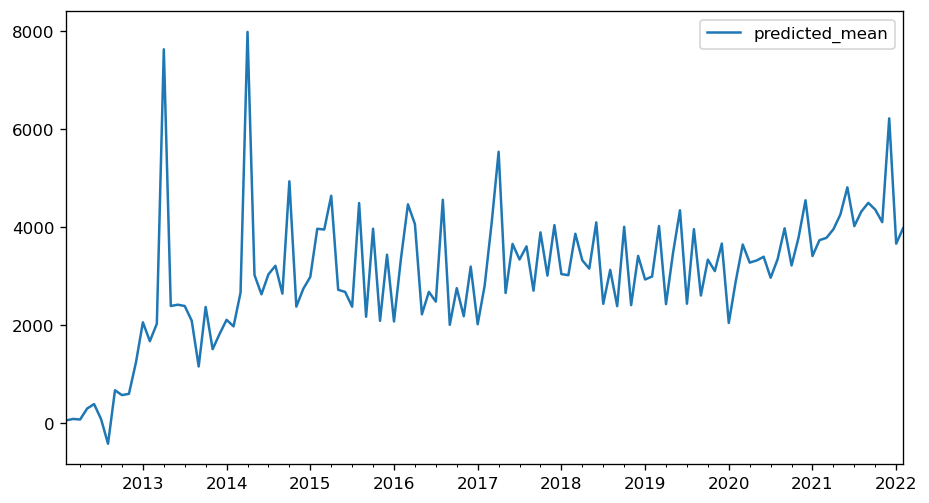

In [74]:
forecast = results.predict(dynamic=False)
forecast[1:].plot(legend=True)
monthyr.monthyr_profit.plot(legend=True)
# plt.ylabel('Sales Volume (Millions)');

In [252]:
monthyr.isna().sum()

monthyr_profit      0
forecast          122
dtype: int64

In [214]:
df.columns

Index(['date', 'store_number', 'store_name', 'address', 'city', 'zip_code',
       'county', 'category_name', 'vendor_number', 'vendor_name',
       'item_description', 'pack', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'Profit_per_bottle', 'Profit_per_sale', 'Store Type', 'LiquorType',
       'Bottle Size', 'Longitude', 'Latitude', 'day_name', 'year_month'],
      dtype='object')

# Stepwise Regression for important features

In [47]:
df[numerical_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8477 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pack                 8477 non-null   int32  
 1   state_bottle_cost    8477 non-null   float32
 2   state_bottle_retail  8477 non-null   float32
 3   bottles_sold         8477 non-null   int32  
 4   volume_sold_liters   8477 non-null   float32
 5   Longitude            8477 non-null   float64
 6   Latitude             8477 non-null   float64
dtypes: float32(3), float64(2), int32(2)
memory usage: 364.2 KB


In [44]:
#separate types of columns/features
#categorical_features = df.select_dtypes(include = ["object"]).columns
categorical_features=['LiquorType', 'Store Type', 'Bottle Size', 'county', 'city']
numerical_features = ['pack', 'state_bottle_cost', 'state_bottle_retail','bottles_sold','volume_sold_liters',
                     'Longitude', 'Latitude']

numerics=df[numerical_features]

cats=df[categorical_features]


In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(df[numerical_features])


In [51]:
df[numerical_features]=scaled

In [52]:
df[numerical_features]

pack  state_bottle_cost  state_bottle_retail  bottles_sold  \
0    -0.805888          -0.055494            -0.055635     -0.160005   
1    -0.805888          -0.062366            -0.062456     -0.160005   
2    -0.805888          -0.062366            -0.062456     -0.334511   
3     0.076186           0.011391             0.011149      0.049402   
4    -0.805888           0.309166             0.309026     -0.160005   
...        ...                ...                  ...           ...   
9995  0.076186           0.084536             0.084447      0.049402   
9996 -0.805888          -0.032283            -0.032423     -0.160005   
9997  0.076186           0.011391             0.011149     -0.264709   
9998  0.076186          -0.118409            -0.118549      0.049402   
9999  0.076186          -0.097641            -0.097781     -0.264709   

      volume_sold_liters  Longitude  Latitude  
0               0.025521   0.755745  0.245534  
1               0.025521  -0.772373  1.398939  
2              -0.271449   0.309881 -1.417933  
3              -0.025388  -0.472565 -0.507447  
4              -0.178116   0.813414 -0.260865  
...                  ...        ...       ...  
9995           -0.025388   0.859283 -0.389928  
9996            0.025521   0.376770  0.950625  
9997           -0.254479  -0.772373  1.398939  
9998           -0.025388   1.492644 -0.538270  
9999           -0.310479   1.453183 -0.530981  

[8477 rows x 7 columns]

In [ ]:
#numerics=pd.DataFrame(numerics)

In [53]:
#dummifying the categorical features
dummy= pd.get_dummies(cats, drop_first=True)

In [54]:
dummy

LiquorType_beer  LiquorType_brandy  LiquorType_cocktail mix  \
0                   0                  0                        0   
1                   0                  0                        0   
2                   0                  0                        0   
3                   0                  0                        0   
4                   0                  0                        0   
...               ...                ...                      ...   
9995                0                  1                        0   
9996                0                  0                        0   
9997                0                  0                        0   
9998                0                  0                        0   
9999                0                  0                        0   

      LiquorType_gifts  LiquorType_gin  LiquorType_liqueurs  \
0                    0               0                    0   
1                    0               0                    0   
2                    0               0                    0   
3                    0               1                    0   
4                    0               0                    0   
...                ...             ...                  ...   
9995                 0               0                    0   
9996                 0               0                    0   
9997                 0               1                    0   
9998                 0               0                    0   
9999                 0               0                    0   

      LiquorType_mezcal  LiquorType_moonshine  LiquorType_rum  \
0                     0                     0               0   
1                     0                     0               0   
2                     0                     0               0   
3                     0                     0               0   
4                     0                     0               0   
...                 ...                   ...             ...   
9995                  0                     0               0   
9996                  0                     0               0   
9997                  0                     0               0   
9998                  0                     0               0   
9999                  0                     0               0   

      LiquorType_schnapps  LiquorType_tequila  LiquorType_vodka  \
0                       0                   0                 0   
1                       0                   0                 1   
2                       0                   0                 1   
3                       0                   0                 0   
4                       0                   0                 0   
...                   ...                 ...               ...   
9995                    0                   0                 0   
9996                    0                   0                 0   
9997                    0                   0                 0   
9998                    0                   0                 0   
9999                    0                   0                 1   

      LiquorType_whisky/bourbon/scotch  Store Type_Drug Store  Store Type_Gas  \
0                                    1                      0               0   
1                                    0                      0               0   
2                                    0                      0               1   
3                                    0                      1               0   
4                                    1                      0               0   
...                                ...                    ...             ...   
9995                                 0                      0               0   
9996                                 1                      0               0   
9997                                 0                      0               0   
9998                    

In [130]:
x=pd.concat([dummy, df[numerical_features]], axis=1)
y = np.log(df['Profit_per_sale']+1)

In [131]:
# from sklearn.preprocessing import RobustScaler
# trans = RobustScaler()
# numerics= trans.fit_transform(x)
x=sm.add_constant(x)

In [132]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test=train_test_split(x,y, test_size=.3)

In [133]:
import numpy as np
import statsmodels.api as sm
# def get_stats():
#   
results=sm.OLS(Y_train,X_train).fit()
print(results.summary())
# get_stats()

                            OLS Regression Results                            
Dep. Variable:        Profit_per_sale   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     42.04
Date:                Fri, 25 Mar 2022   Prob (F-statistic):               0.00
Time:                        18:53:36   Log-Likelihood:                -6676.2
No. Observations:                5933   AIC:                         1.359e+04
Df Residuals:                    5814   BIC:                         1.439e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [134]:
pred=results.predict(X_test)

In [135]:
import sklearn.metrics as skl
skl.r2_score(Y_test, pred)

0.43714046146607943

In [72]:
x.isna().sum()

LiquorType_beer                     0
LiquorType_brandy                   0
LiquorType_cocktail mix             0
LiquorType_gifts                    0
LiquorType_gin                      0
LiquorType_liqueurs                 0
LiquorType_mezcal                   0
LiquorType_moonshine                0
LiquorType_rum                      0
LiquorType_schnapps                 0
LiquorType_tequila                  0
LiquorType_vodka                    0
LiquorType_whisky/bourbon/scotch    0
Store Type_Drug Store               0
Store Type_Gas                      0
Store Type_Liquor Store             0
Store Type_Supermarket              0
Bottle Size_1000                    0
Bottle Size_200                     0
Bottle Size_375                     0
Bottle Size_750                     0
Bottle Size_Other                   0
Bottle Size_c                       0
county_appanoose                    0
county_benton                       0
county_black hawk                   0
county_boone

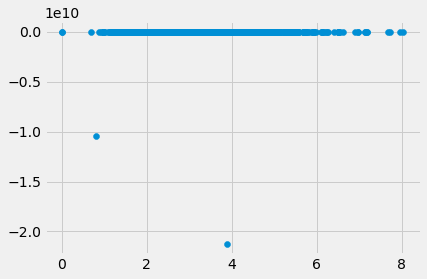

In [169]:
from sklearn import linear_model

lm = linear_model.LinearRegression() 
#generate fit of model base on training set

model = lm.fit(X_train, Y_train) 
#generate predicted values of y_test from X_test based off of training set
predictions = lm.predict(X_test)
#plotting predicted ys against y values in test set 
plt.scatter(Y_test, predictions)


In [175]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso = LassoCV(alphas=np.arange(0, 1, 0.01), cv=cv, n_jobs=-1)

In [177]:
lasso.fit(X_train, Y_train);

In [179]:
lasso.score(X_train, Y_train)

0.3646943235356821

In [180]:
lasso.score(X_test, Y_test)

0.34877544374233105

Lasso picked 10 features and eliminated the other 175 features


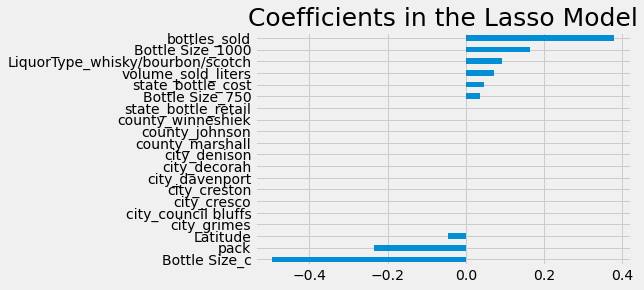

In [182]:
# Plot important coefficients of 2nd model
coefs1 = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs1 != 0)) + " features and eliminated the other " +  \
      str(sum(coefs1 == 0)) + " features")
imp_coefs = pd.concat([coefs1.sort_values().head(10),
                     coefs1.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model", fontsize=25)
plt.show()

In [138]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [154]:
kmeans = KMeans(
init="random",
n_clusters=5,
n_init=10,
max_iter=300,
    random_state=42)


In [155]:
 kmeans.fit(x)

KMeans(init='random', n_clusters=5, random_state=42)

In [156]:
 # The lowest SSE value
kmeans.inertia_

62517.071906984514

In [157]:
kmeans.cluster_centers_

array([[ 1.00000000e+00,  6.78656261e-04,  2.95215473e-02,
         4.03800475e-02,  1.93417034e-02,  4.41126569e-02,
         1.39463862e-01,  6.78656261e-04,  4.41126569e-03,
         1.02137767e-01,  6.04004072e-02,  5.76857822e-02,
         2.27349847e-01,  2.68069223e-01,  7.87241262e-02,
         1.35731252e-03,  2.18187988e-01,  6.97997964e-01,
         1.39124533e-01,  6.78656261e-04,  1.86630472e-02,
         7.57719715e-01,  2.13776722e-02,  6.14183916e-02,
         1.18764846e-02,  1.62630326e-19, -1.38777878e-16,
         2.51102816e-02,  9.54097912e-17, -8.94466792e-19,
        -1.99493200e-17,  0.00000000e+00,  3.12181880e-02,
         1.83237190e-02, -1.04083409e-16,  6.24500451e-17,
         9.54097912e-18,  1.25551408e-02,  3.46944695e-18,
         5.76857822e-03,  3.46944695e-18,  1.79843909e-02,
         5.15778758e-02,  2.37529691e-03, -8.94466792e-19,
        -1.31838984e-16, -7.63278329e-17, -6.07153217e-18,
        -1.78893358e-18, -1.73472348e-18,  8.14387513e-0

In [158]:
# The number of iterations required to converge
kmeans.n_iter_

26

In [163]:
kmeans_kwargs = {
 "init": "random", "n_init": 10,"max_iter": 300,"random_state": 42}


sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

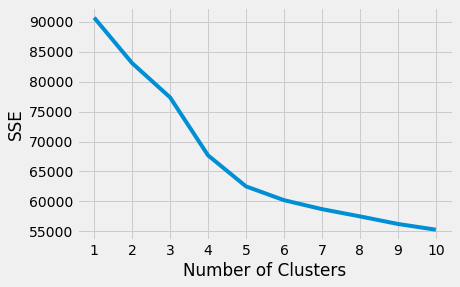

In [166]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [165]:
kl = KneeLocator(
range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

5

In [ ]:
#products=products.drop(['List Date', 'Report Date','UPC','SCC'] , axis=1)

In [ ]:
#products=pd.read_csv('Iowa_Liquor_Products.csv')